In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scipy import spatial
%matplotlib inline
sns.set_style("white")
plt.rcParams.update({'font.size': 20})
from karateclub import DeepWalk
import sklearn.utils

In [2]:
def extend_users_df_with_relational_features(users_df):
    users_df['freebase_nmf_array'] = users_df[['freebase_nmf_0', 'freebase_nmf_1', 'freebase_nmf_2', 'freebase_nmf_3', 'freebase_nmf_4', 'freebase_nmf_5', 'freebase_nmf_6', 'freebase_nmf_7', 'freebase_nmf_8', 'freebase_nmf_9', 'freebase_nmf_10', 'freebase_nmf_11', 'freebase_nmf_12', 'freebase_nmf_13', 'freebase_nmf_14', 'freebase_nmf_15', 'freebase_nmf_16', 'freebase_nmf_17', 'freebase_nmf_18', 'freebase_nmf_19']].values.tolist()
    users_df['allmusic_genre_array'] = users_df[['allmusic_rnb', 'allmusic_rap', 'allmusic_electronic', 'allmusic_rock', 'allmusic_new age', 'allmusic_classical', 'allmusic_reggae', 'allmusic_blues', 'allmusic_country', 'allmusic_world', 'allmusic_folk', 'allmusic_easy listening', 'allmusic_jazz', 'allmusic_vocal', "allmusic_children's", 'allmusic_punk', 'allmusic_alternative', 'allmusic_spoken word', 'allmusic_pop', 'allmusic_heavy metal']].values.tolist()
    users_df['UAM_nmf_array'] = users_df[['UAM_nmf_0', 'UAM_nmf_1', 'UAM_nmf_2', 'UAM_nmf_3', 'UAM_nmf_4', 'UAM_nmf_5', 'UAM_nmf_6', 'UAM_nmf_7', 'UAM_nmf_8', 'UAM_nmf_9', 'UAM_nmf_10', 'UAM_nmf_11', 'UAM_nmf_12', 'UAM_nmf_13', 'UAM_nmf_14', 'UAM_nmf_15', 'UAM_nmf_16', 'UAM_nmf_17', 'UAM_nmf_18', 'UAM_nmf_19']].values.tolist()
    users_df['allmusic_genre_array'] = users_df['allmusic_genre_array'].apply(lambda x: np.array(x))
    users_df['freebase_nmf_array'] = users_df['freebase_nmf_array'].apply(lambda x: np.array(x))
    users_df['UAM_nmf_array'] = users_df['UAM_nmf_array'].apply(lambda x: np.array(x))
    return users_df

def calculate_cosine_similarity_for_vector_features(df, columns):
    for column in columns:
        df['cosine_similarity_'+column] = df.apply(lambda x: cosine_similarity(x['user1_'+column], x['user2_'+column]), axis=1)
    return df

def cosine_similarity(list1, list2):
    return 1 - spatial.distance.cosine(list1, list2)

In [4]:
links_df = pd.read_csv('dataframes/links_dfs/0/links_df_full.csv', index_col=False).drop(columns=['Unnamed: 0'])
links_df = links_df[links_df.label==1]
users_df = pd.read_csv('dataframes/users_df_no_missing_values.csv', index_col=False).drop(columns=['Unnamed: 0'])
users_df = extend_users_df_with_relational_features(users_df)

users1_df = pd.DataFrame([x for x in links_df['user1_user_id'].values]).rename(columns={0:'user_id'}).merge(users_df, how='left', on='user_id').add_prefix('user1_')
users2_df = pd.DataFrame([x for x in links_df['user2_user_id'].values]).rename(columns={0:'user_id'}).merge(users_df, how='left', on='user_id').add_prefix('user2_')
links_df = pd.concat([users1_df, users2_df.set_index(users1_df.index)], axis=1)
links_df['cosine_similarity_'+'UAM_nmf_array'] = links_df.apply(lambda x: cosine_similarity(x['user1_'+'UAM_nmf_array'], x['user2_'+'UAM_nmf_array']), axis=1)
links_df['cosine_similarity_'+'freebase_nmf_array'] = links_df.apply(lambda x: cosine_similarity(x['user1_'+'freebase_nmf_array'], x['user2_'+'freebase_nmf_array']), axis=1)
links_df['label'] = 1
links_df = calculate_cosine_similarity_for_vector_features(links_df, ['allmusic_genre_array', 'freebase_nmf_array', 'UAM_nmf_array'])

In [5]:
edges = list(zip(links_df.user1_user_id, links_df.user2_user_id))
G = nx.Graph()
for edge in edges:
    G.add_edge(edge[0], edge[1])
    
# keep only users in the LCC
#G_lcc = [G.subgraph(c).copy() for c in nx.connected_components(G)][1]
#users_df = users_df[users_df['user_id'].isin(G_lcc.nodes)]
#links_df = links_df[(links_df['user1_user_id'].isin(G_lcc.nodes))&(links_df['user2_user_id'].isin(G_lcc.nodes))]

In [6]:
df_subset = links_df[['user1_playcount_lognorm', 
                'user1_novelty_artist_avg_month', 
                'user1_novelty_artist_avg_6months', 
                'user1_novelty_artist_avg_year',
                'user1_mainstreaminess_avg_month',
                'user1_mainstreaminess_avg_6months',
                'user1_mainstreaminess_avg_year',
                'user1_mainstreaminess_global',
                'user1_cnt_listeningevents_lognorm',
                'user1_cnt_distinct_tracks_lognorm',
                'user1_cnt_distinct_artists_lognorm',
                'user1_cnt_listeningevents_per_week_lognorm',
                'user1_allmusic_weighted_average_diversity',
                'user1_allmusic_genre_coverage_diversity',
                'user1_allmusic_entropy_diversity',
                'user1_freebase_weighted_average_diversity',
                'user1_freebase_genre_coverage_diversity',
                'user1_freebase_entropy_diversity',
                'user2_playcount_lognorm', 
                'user2_novelty_artist_avg_month', 
                'user2_novelty_artist_avg_6months', 
                'user2_novelty_artist_avg_year',
                'user2_mainstreaminess_avg_month',
                'user2_mainstreaminess_avg_6months',
                'user2_mainstreaminess_avg_year',
                'user2_mainstreaminess_global',
                'user2_cnt_listeningevents_lognorm',
                'user2_cnt_distinct_tracks_lognorm',
                'user2_cnt_distinct_artists_lognorm',
                'user2_cnt_listeningevents_per_week_lognorm',
                'user2_allmusic_weighted_average_diversity',
                'user2_allmusic_genre_coverage_diversity',
                'user2_allmusic_entropy_diversity',
                'user2_freebase_weighted_average_diversity',
                'user2_freebase_genre_coverage_diversity',
                'user2_freebase_entropy_diversity',
                'cosine_similarity_allmusic_genre_array',
                'cosine_similarity_freebase_nmf_array',
                'cosine_similarity_UAM_nmf_array'
                     ]]
df_subset['user1_playcount_lognorm'].fillna(df_subset['user1_playcount_lognorm'].mean(), inplace=True)
df_subset['user1_allmusic_weighted_average_diversity'].fillna(df_subset['user1_allmusic_weighted_average_diversity'].mean(), inplace=True)
df_subset['user1_allmusic_genre_coverage_diversity'].fillna(df_subset['user1_allmusic_genre_coverage_diversity'].mean(), inplace=True)
df_subset['user1_allmusic_entropy_diversity'].fillna(df_subset['user1_allmusic_entropy_diversity'].mean(), inplace=True)
df_subset['user1_freebase_weighted_average_diversity'].fillna(df_subset['user1_freebase_weighted_average_diversity'].mean(), inplace=True)
df_subset['user1_freebase_genre_coverage_diversity'].fillna(df_subset['user1_freebase_genre_coverage_diversity'].mean(), inplace=True)
df_subset['user1_freebase_entropy_diversity'].fillna(df_subset['user1_freebase_entropy_diversity'].mean(), inplace=True)

df_subset['user2_playcount_lognorm'].fillna(df_subset['user2_playcount_lognorm'].mean(), inplace=True)
df_subset['user2_allmusic_weighted_average_diversity'].fillna(df_subset['user2_allmusic_weighted_average_diversity'].mean(), inplace=True)
df_subset['user2_allmusic_genre_coverage_diversity'].fillna(df_subset['user2_allmusic_genre_coverage_diversity'].mean(), inplace=True)
df_subset['user2_allmusic_entropy_diversity'].fillna(df_subset['user2_allmusic_entropy_diversity'].mean(), inplace=True)
df_subset['user2_freebase_weighted_average_diversity'].fillna(df_subset['user2_freebase_weighted_average_diversity'].mean(), inplace=True)
df_subset['user2_freebase_genre_coverage_diversity'].fillna(df_subset['user2_freebase_genre_coverage_diversity'].mean(), inplace=True)
df_subset['user2_freebase_entropy_diversity'].fillna(df_subset['user2_freebase_entropy_diversity'].mean(), inplace=True)

df_subset['cosine_similarity_allmusic_genre_array'].fillna(df_subset['cosine_similarity_allmusic_genre_array'].mean(), inplace=True)
df_subset['cosine_similarity_freebase_nmf_array'].fillna(df_subset['cosine_similarity_freebase_nmf_array'].mean(), inplace=True)
df_subset['cosine_similarity_UAM_nmf_array'].fillna(df_subset['cosine_similarity_UAM_nmf_array'].mean(), inplace=True)

/usr/local/lib/python3.8/dist-packages/pandas/core/series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [7]:
col_name = df_subset.columns.to_series()[np.isinf(df_subset).any()]
print(col_name)

Series([], dtype: object)


In [8]:
for column in df_subset.columns:
    if '2' in column or 'label' in column or 'cosine' in column:
        continue
    print(column)
    print(pearsonr(df_subset[column], df_subset[column.replace('1', '2')]))
    print('\n')

user1_playcount_lognorm
(0.052783357367574106, 7.510430236846299e-50)


user1_novelty_artist_avg_month
(0.06296259359325274, 3.333194933021137e-70)


user1_novelty_artist_avg_6months
(0.11163261756178841, 2.0836574814202994e-217)


user1_novelty_artist_avg_year
(0.05753211351619856, 6.697583532218506e-59)


user1_mainstreaminess_avg_month
(0.055091853765127034, 3.745049061172051e-54)


user1_mainstreaminess_avg_6months
(0.050393935259174835, 1.3658156539973985e-45)


user1_mainstreaminess_avg_year
(0.04279643842138453, 2.3760875460687416e-33)


user1_mainstreaminess_global
(0.10537217935205874, 8.378633775202589e-194)


user1_cnt_listeningevents_lognorm
(0.026725003583994475, 5.810626554051674e-14)


user1_cnt_distinct_tracks_lognorm
(0.07921367900394395, 3.8915565534978494e-110)


user1_cnt_distinct_artists_lognorm
(0.10559388121259898, 1.2912758414770582e-194)


user1_cnt_listeningevents_per_week_lognorm
(0.09045062326945053, 3.9315040413764274e-143)


user1_allmusic_weighted_average

In [ ]:
features_to_plot = ['novelty_artist_avg_month',
 'novelty_artist_avg_6months',
 'novelty_artist_avg_year',
 'mainstreaminess_avg_month',
 'mainstreaminess_avg_6months',
 'mainstreaminess_avg_year',
 'mainstreaminess_global',
 'cnt_distinct_tracks_lognorm',
 'cnt_distinct_artists_lognorm',
 'freebase_weighted_average_diversity',
 'freebase_genre_coverage_diversity',
 'freebase_entropy_diversity']
sns.kdeplot(data=users_df['freebase_entropy_diversity'], color='black', linewidth=15)
plt.axis('off')
plt.savefig('figures/'+'freebase_entropy_diversity'+'_dist.pdf',dpi=300, bbox_inches = "tight")

In [15]:
plt.rcParams.update({'figure.figsize' : (9,5.06)})
# sns.distplot(users_df.novelty_artist_avg_month, kde=False)
# plt.savefig('figures/novelty_artist_avg_month.pdf',dpi=300, bbox_inches = "tight")

/home/tduricic/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


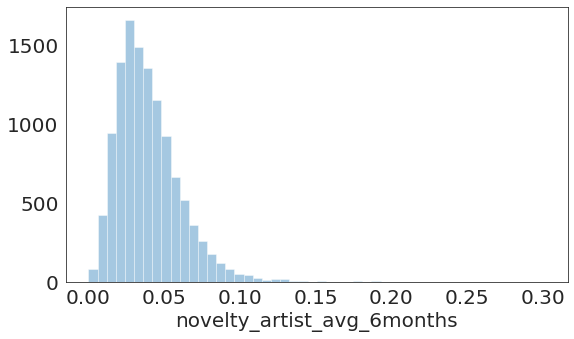

In [16]:
sns.distplot(users_df.novelty_artist_avg_6months, kde=False)
plt.savefig('figures/novelty_artist_avg_6months.pdf',dpi=300, bbox_inches = "tight")

/home/tduricic/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


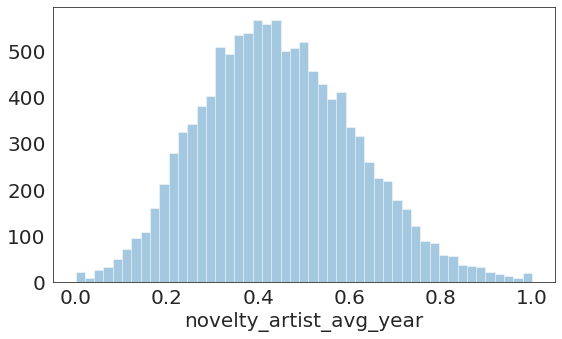

In [17]:
sns.distplot(users_df.novelty_artist_avg_year, kde=False)
plt.savefig('figures/novelty_artist_avg_year.pdf',dpi=300, bbox_inches = "tight")

/home/tduricic/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


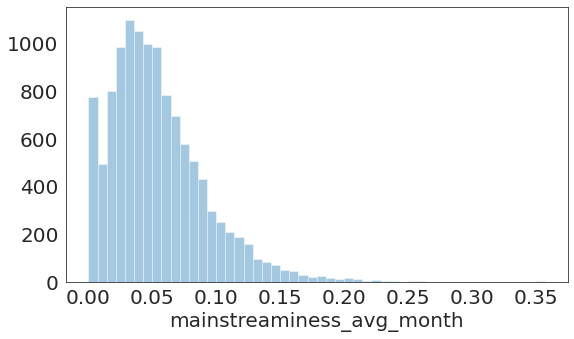

In [18]:
sns.distplot(users_df.mainstreaminess_avg_month, kde=False)
plt.savefig('figures/mainstreaminess_avg_month.pdf',dpi=300, bbox_inches = "tight")

/home/tduricic/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


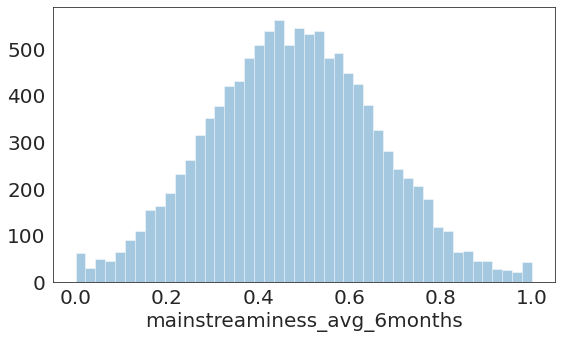

In [19]:
sns.distplot(users_df.mainstreaminess_avg_6months, kde=False)
plt.savefig('figures/mainstreaminess_avg_6months.pdf',dpi=300, bbox_inches = "tight")

/home/tduricic/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


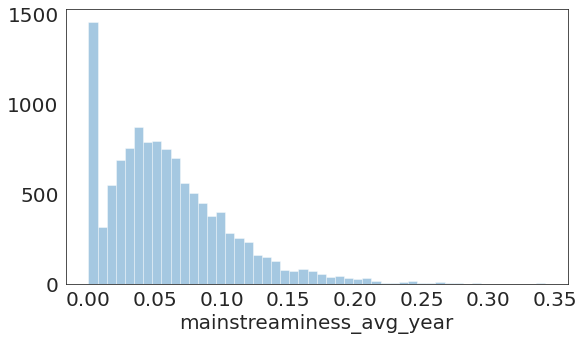

In [20]:
sns.distplot(users_df.mainstreaminess_avg_year, kde=False)
plt.savefig('figures/mainstreaminess_avg_year.pdf',dpi=300, bbox_inches = "tight")

/home/tduricic/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


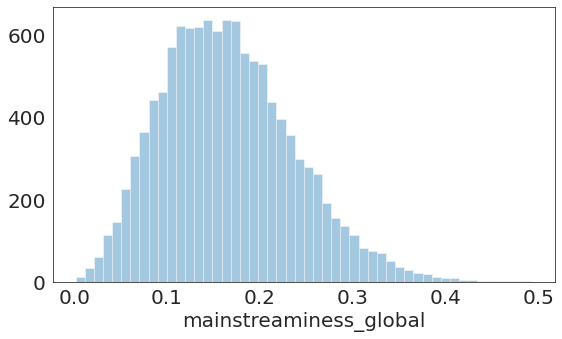

In [21]:
sns.distplot(users_df.mainstreaminess_global, kde=False)
plt.savefig('figures/mainstreaminess_global.pdf',dpi=300, bbox_inches = "tight")

/home/tduricic/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


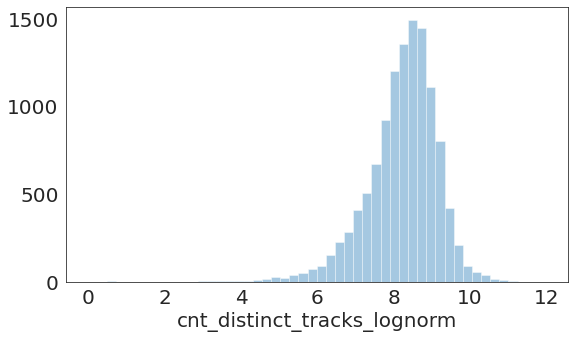

In [22]:
sns.distplot(users_df.cnt_distinct_tracks_lognorm, kde=False)
plt.savefig('figures/cnt_distinct_tracks_lognorm.pdf',dpi=300, bbox_inches = "tight")

/home/tduricic/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


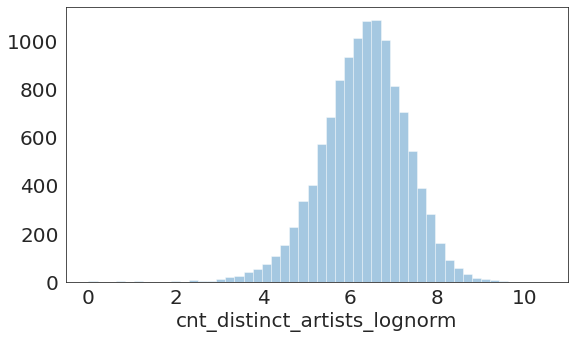

In [23]:
sns.distplot(users_df.cnt_distinct_artists_lognorm, kde=False)
plt.savefig('figures/cnt_distinct_artists_lognorm.pdf',dpi=300, bbox_inches = "tight")

/home/tduricic/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


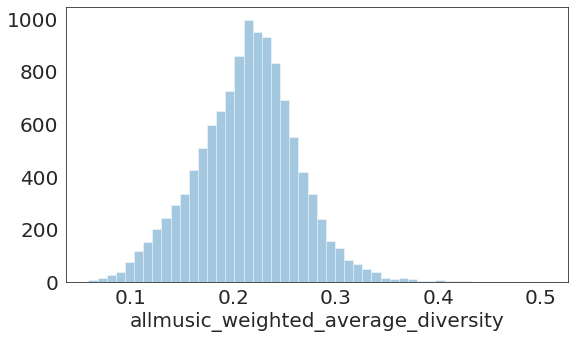

In [24]:
sns.distplot(users_df.allmusic_weighted_average_diversity, kde=False)
plt.savefig('figures/allmusic_weighted_average_diversity.pdf',dpi=300, bbox_inches = "tight")

/home/tduricic/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


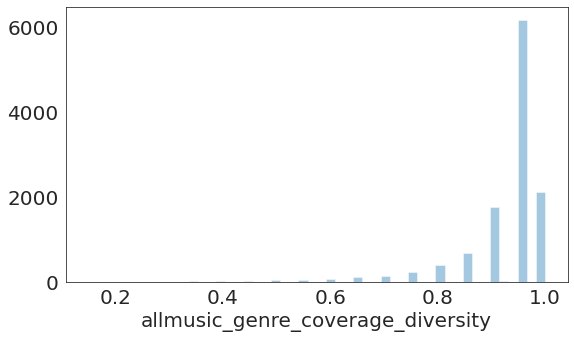

In [25]:
sns.distplot(users_df.allmusic_genre_coverage_diversity, kde=False)
plt.savefig('figures/allmusic_genre_coverage_diversity.pdf',dpi=300, bbox_inches = "tight")

/home/tduricic/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


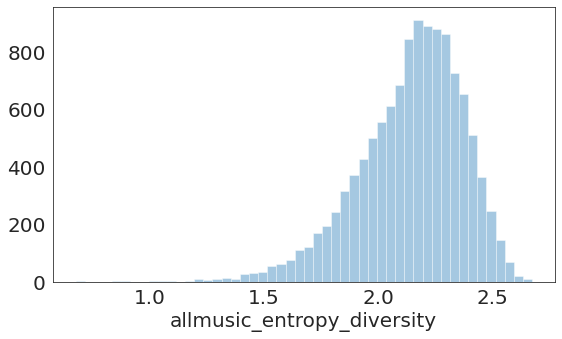

In [26]:
sns.distplot(users_df.allmusic_entropy_diversity, kde=False)
plt.savefig('figures/allmusic_entropy_diversity.pdf',dpi=300, bbox_inches = "tight")

/home/tduricic/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


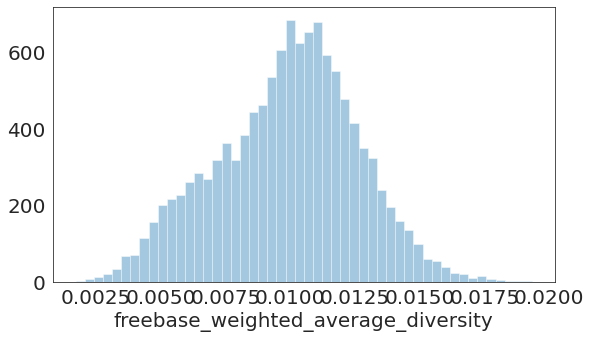

In [27]:
sns.distplot(users_df.freebase_weighted_average_diversity, kde=False)
plt.savefig('figures/freebase_weighted_average_diversity.pdf',dpi=300, bbox_inches = "tight")

/home/tduricic/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


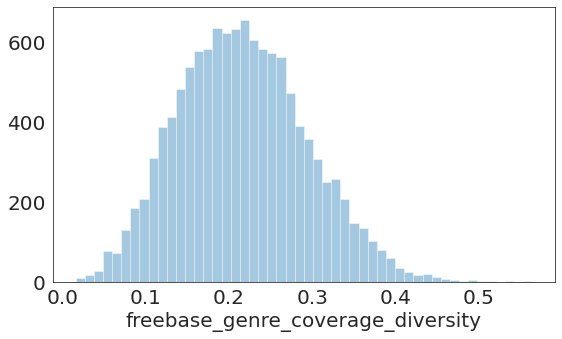

In [28]:
sns.distplot(users_df.freebase_genre_coverage_diversity, kde=False)
plt.savefig('figures/freebase_genre_coverage_diversity.pdf',dpi=300, bbox_inches = "tight")

/home/tduricic/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


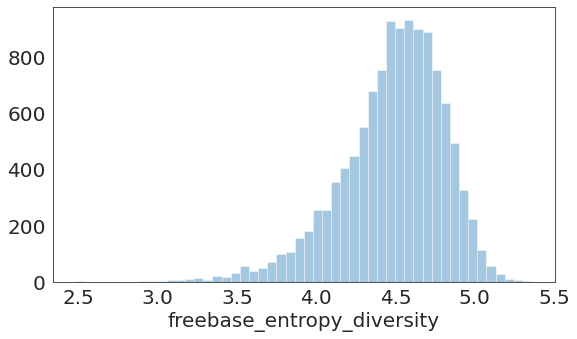

In [29]:
sns.distplot(users_df.freebase_entropy_diversity, kde=False)
plt.savefig('figures/freebase_entropy_diversity.pdf',dpi=300, bbox_inches = "tight")

In [9]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", title='', **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)
    ax.set_title(title)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=False, bottom=False,
                   labeltop=False, labelbottom=True)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    #ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if j > i:
                continue
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [10]:
# metric = 'mainstreaminess_global'
# metric = 'novelty_artist_avg_6months'
metric = 'freebase_weighted_average_diversity'
my_dict = users_df.groupby(['user_groups_'+metric]).count().user_id.to_dict()
total_edges = len(links_df)
total_nodes = len(users_df)
results = {}
for key1 in my_dict:
    for key2 in my_dict:
        if key1 == key2:
            expected_edges = (my_dict[key1]/total_nodes)*(my_dict[key2]/total_nodes) * total_edges
            real_edges = len(links_df[(links_df['user1_user_groups_'+metric+'_'+key1]==True)&((links_df['user2_user_groups_'+metric+'_'+key2]==True))])
            cosine_similarity_allmusic_genre_array_values = links_df[(links_df['user1_user_groups_'+metric+'_'+key1]==True)&((links_df['user2_user_groups_'+metric+'_'+key2]==True))].cosine_similarity_allmusic_genre_array.values
            cosine_similarity_freebase_nmf_array_values = links_df[(links_df['user1_user_groups_'+metric+'_'+key1]==True)&((links_df['user2_user_groups_'+metric+'_'+key2]==True))].cosine_similarity_freebase_nmf_array.values
            cosine_similarity_UAM_nmf_array_values = links_df[(links_df['user1_user_groups_'+metric+'_'+key1]==True)&((links_df['user2_user_groups_'+metric+'_'+key2]==True))].cosine_similarity_UAM_nmf_array.values
        else:
            expected_edges = 2*(my_dict[key1]/total_nodes)*(my_dict[key2]/total_nodes) * total_edges
            real_edges = len(links_df[(links_df['user1_user_groups_'+metric+'_'+key1]==True)&((links_df['user2_user_groups_'+metric+'_'+key2]==True))]) + len(links_df[(links_df['user1_user_groups_'+metric+'_'+key2]==True)&((links_df['user2_user_groups_'+metric+'_'+key1]==True))])
#         results[(key1,key2)] = (expected_edges, real_edges, real_edges/expected_edges)
            cosine_similarity_allmusic_genre_array_values = np.concatenate([links_df[(links_df['user1_user_groups_'+metric+'_'+key1]==True)&((links_df['user2_user_groups_'+metric+'_'+key2]==True))].cosine_similarity_allmusic_genre_array.values, links_df[(links_df['user1_user_groups_'+metric+'_'+key2]==True)&((links_df['user2_user_groups_'+metric+'_'+key1]==True))].cosine_similarity_allmusic_genre_array.values])
            cosine_similarity_freebase_nmf_array_values = np.concatenate([links_df[(links_df['user1_user_groups_'+metric+'_'+key1]==True)&((links_df['user2_user_groups_'+metric+'_'+key2]==True))].cosine_similarity_freebase_nmf_array.values, links_df[(links_df['user1_user_groups_'+metric+'_'+key2]==True)&((links_df['user2_user_groups_'+metric+'_'+key1]==True))].cosine_similarity_freebase_nmf_array.values])
            cosine_similarity_UAM_nmf_array_values = np.concatenate([links_df[(links_df['user1_user_groups_'+metric+'_'+key1]==True)&((links_df['user2_user_groups_'+metric+'_'+key2]==True))].cosine_similarity_UAM_nmf_array.values, links_df[(links_df['user1_user_groups_'+metric+'_'+key2]==True)&((links_df['user2_user_groups_'+metric+'_'+key1]==True))].cosine_similarity_UAM_nmf_array.values])
        results[(key1,key2)] = {
            'expected_edges':expected_edges, 
            'real_edges':real_edges, 
            'real_expected_ratio': real_edges/expected_edges,
            'cosine_similarity_allmusic_mean':np.mean(cosine_similarity_allmusic_genre_array_values),
            'cosine_similarity_freebase_nmf_mean':np.mean(cosine_similarity_freebase_nmf_array_values),
            'cosine_similarity_UAM_nmf_mean':np.mean(cosine_similarity_UAM_nmf_array_values)
        }
results

{('high', 'high'): {'expected_edges': 4903.376683551758,
  'real_edges': 5989,
  'real_expected_ratio': 1.2214032056908732,
  'cosine_similarity_allmusic_mean': 0.9168298960963197,
  'cosine_similarity_freebase_nmf_mean': 0.6028685747017608,
  'cosine_similarity_UAM_nmf_mean': 0.4748758935282631},
 ('high', 'low'): {'expected_edges': 17463.89843998829,
  'real_edges': 13174,
  'real_expected_ratio': 0.7543561963137959,
  'cosine_similarity_allmusic_mean': 0.793889643334732,
  'cosine_similarity_freebase_nmf_mean': 0.43389573554624455,
  'cosine_similarity_UAM_nmf_mean': 0.3494265459783364},
 ('high', 'medium'): {'expected_edges': 12089.877704441435,
  'real_edges': 11977,
  'real_expected_ratio': 0.9906634535765431,
  'cosine_similarity_allmusic_mean': 0.8986710819619838,
  'cosine_similarity_freebase_nmf_mean': 0.5363371433639703,
  'cosine_similarity_UAM_nmf_mean': 0.41421072243358564},
 ('low', 'high'): {'expected_edges': 17463.89843998829,
  'real_edges': 13174,
  'real_expected_ra

In [37]:
namings_map = {
    'mainstreaminess_global':'mainstreaminess',
    'freebase_weighted_average_diversity':'diversity',
    'novelty_artist_avg_6months':'novelty'
}
nodes_per_group = {
    'mainstreaminess_global': users_df.groupby(['user_groups_mainstreaminess_global']).count().user_id.to_dict(),
    'freebase_weighted_average_diversity': users_df.groupby(['user_groups_freebase_weighted_average_diversity']).count().user_id.to_dict(),
    'novelty_artist_avg_6months': users_df.groupby(['user_groups_novelty_artist_avg_6months']).count().user_id.to_dict()
}
keys = ['mainstreaminess_global|high', 
        'mainstreaminess_global|medium', 
        'mainstreaminess_global|low',
        'freebase_weighted_average_diversity|high',
        'freebase_weighted_average_diversity|medium',
        'freebase_weighted_average_diversity|low',
        'novelty_artist_avg_6months|high',
        'novelty_artist_avg_6months|medium',
        'novelty_artist_avg_6months|low']
total_edges = len(links_df)
total_nodes = len(users_df)
results = {}
for key1 in keys:
    for key2 in keys:
        metric1 = key1.split('|')[0]
        user_group1 = key1.split('|')[1]
        metric2 = key2.split('|')[0]
        user_group2 = key2.split('|')[1]
        if key1 == key2:
            expected_edges = (nodes_per_group[metric1][user_group1]/total_nodes)*(nodes_per_group[metric2][user_group2]/total_nodes) * total_edges
            real_edges = len(links_df[(links_df['user1_user_groups_'+metric1+'_'+user_group1]==True)&((links_df['user2_user_groups_'+metric2+'_'+user_group2]==True))])
            cosine_similarity_allmusic_genre_array_values = links_df[(links_df['user1_user_groups_'+metric1+'_'+user_group1]==True)&((links_df['user2_user_groups_'+metric2+'_'+user_group2]==True))].cosine_similarity_allmusic_genre_array.values
            cosine_similarity_freebase_nmf_array_values = links_df[(links_df['user1_user_groups_'+metric1+'_'+user_group1]==True)&((links_df['user2_user_groups_'+metric2+'_'+user_group2]==True))].cosine_similarity_freebase_nmf_array.values
            cosine_similarity_UAM_nmf_array_values = links_df[(links_df['user1_user_groups_'+metric1+'_'+user_group1]==True)&((links_df['user2_user_groups_'+metric2+'_'+user_group2]==True))].cosine_similarity_UAM_nmf_array.values
        else:
            expected_edges = 2*(nodes_per_group[metric1][user_group1]/total_nodes)*(nodes_per_group[metric2][user_group2]/total_nodes) * total_edges
            real_edges = len(links_df[(links_df['user1_user_groups_'+metric1+'_'+user_group1]==True)&((links_df['user2_user_groups_'+metric2+'_'+user_group2]==True))]) + len(links_df[(links_df['user1_user_groups_'+metric2+'_'+user_group2]==True)&((links_df['user2_user_groups_'+metric1+'_'+user_group1]==True))])
            cosine_similarity_allmusic_genre_array_values = np.concatenate([links_df[(links_df['user1_user_groups_'+metric1+'_'+user_group1]==True)&((links_df['user2_user_groups_'+metric2+'_'+user_group2]==True))].cosine_similarity_allmusic_genre_array.values, links_df[(links_df['user1_user_groups_'+metric2+'_'+user_group2]==True)&((links_df['user2_user_groups_'+metric1+'_'+user_group1]==True))].cosine_similarity_allmusic_genre_array.values])
            cosine_similarity_freebase_nmf_array_values = np.concatenate([links_df[(links_df['user1_user_groups_'+metric1+'_'+user_group1]==True)&((links_df['user2_user_groups_'+metric2+'_'+user_group2]==True))].cosine_similarity_freebase_nmf_array.values, links_df[(links_df['user1_user_groups_'+metric2+'_'+user_group2]==True)&((links_df['user2_user_groups_'+metric1+'_'+user_group1]==True))].cosine_similarity_freebase_nmf_array.values])
            cosine_similarity_UAM_nmf_array_values = np.concatenate([links_df[(links_df['user1_user_groups_'+metric1+'_'+user_group1]==True)&((links_df['user2_user_groups_'+metric2+'_'+user_group2]==True))].cosine_similarity_UAM_nmf_array.values, links_df[(links_df['user1_user_groups_'+metric2+'_'+user_group2]==True)&((links_df['user2_user_groups_'+metric1+'_'+user_group1]==True))].cosine_similarity_UAM_nmf_array.values])
        results_key1 = user_group1.capitalize() + ' ' + namings_map[metric1]
        results_key2 = user_group2.capitalize() + ' ' + namings_map[metric2]
        results[(results_key1,results_key2)] = {
            'expected_edges':expected_edges, 
            'real_edges':real_edges, 
            'real_expected_ratio': real_edges/expected_edges,
            'cosine_similarity_allmusic_mean':np.nanmean(cosine_similarity_allmusic_genre_array_values),
            'cosine_similarity_freebase_nmf_mean':np.nanmean(cosine_similarity_freebase_nmf_array_values),
            'cosine_similarity_UAM_nmf_mean':np.nanmean(cosine_similarity_UAM_nmf_array_values),
            'cosine_similarity_allmusic_diff_to_mean':np.nanmean(cosine_similarity_allmusic_genre_array_values)/np.nanmean(links_df.cosine_similarity_allmusic_genre_array),
            'cosine_similarity_freebase_diff_to_mean':np.nanmean(cosine_similarity_freebase_nmf_array_values)/np.nanmean(links_df.cosine_similarity_freebase_nmf_array),
            'cosine_similarity_UAM_nmf_diff_to_mean':np.nanmean(cosine_similarity_UAM_nmf_array_values)/np.nanmean(links_df.cosine_similarity_UAM_nmf_array),
            'cosine_similarity_allmusic_diff_to_median':np.nanmean(cosine_similarity_allmusic_genre_array_values)/np.nanmedian(links_df.cosine_similarity_allmusic_genre_array),
            'cosine_similarity_freebase_diff_to_median':np.nanmean(cosine_similarity_freebase_nmf_array_values)/np.nanmedian(links_df.cosine_similarity_freebase_nmf_array),
            'cosine_similarity_UAM_nmf_diff_to_median':np.nanmean(cosine_similarity_UAM_nmf_array_values)/np.nanmedian(links_df.cosine_similarity_UAM_nmf_array)
        }

In [12]:
len(results)

81

In [32]:
len(links_df)

78989

In [ ]:
for key in 

In [34]:
results.keys()

dict_keys([('High mainstreaminess', 'High mainstreaminess'), ('High mainstreaminess', 'Medium mainstreaminess'), ('High mainstreaminess', 'Low mainstreaminess'), ('High mainstreaminess', 'High diversity'), ('High mainstreaminess', 'Medium diversity'), ('High mainstreaminess', 'Low diversity'), ('High mainstreaminess', 'High novelty'), ('High mainstreaminess', 'Medium novelty'), ('High mainstreaminess', 'Low novelty'), ('Medium mainstreaminess', 'High mainstreaminess'), ('Medium mainstreaminess', 'Medium mainstreaminess'), ('Medium mainstreaminess', 'Low mainstreaminess'), ('Medium mainstreaminess', 'High diversity'), ('Medium mainstreaminess', 'Medium diversity'), ('Medium mainstreaminess', 'Low diversity'), ('Medium mainstreaminess', 'High novelty'), ('Medium mainstreaminess', 'Medium novelty'), ('Medium mainstreaminess', 'Low novelty'), ('Low mainstreaminess', 'High mainstreaminess'), ('Low mainstreaminess', 'Medium mainstreaminess'), ('Low mainstreaminess', 'Low mainstreaminess'), (

In [35]:
my_dict

{'high': 2938, 'low': 5232, 'medium': 3622}

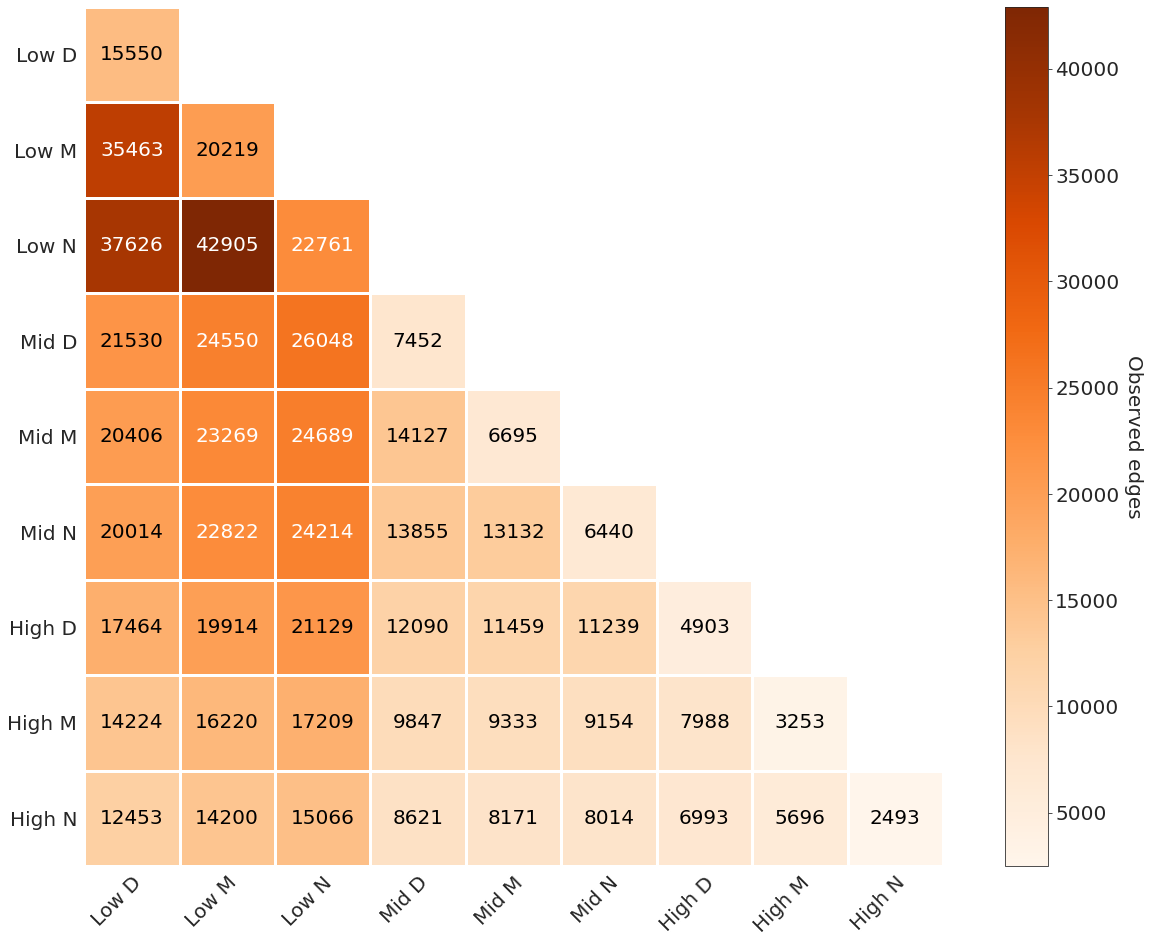

In [34]:
plt.rcParams.update({'figure.figsize' : (18,13.5), 'font.size': 20})
indices = ['Low diversity', 'Low mainstreaminess', 'Low novelty', 'Medium diversity', 'Medium mainstreaminess', 'Medium novelty', 'High diversity', 'High mainstreaminess', 'High novelty']
indices_short = ['Low D', 'Low M', 'Low N', 'Mid D', 'Mid M', 'Mid N', 'High D', 'High M', 'High N']

# indices = ['Diversity low', 'Mainstreaminess low', 'Novelty low', 'Diversity medium', 'Mainstreaminess medium', 'Novelty medium', 'Diversity high', 'Mainstreaminess high', 'Novelty high']
metric = 'expected_edges'
values = np.zeros((len(indices), len(indices)))
for i in range(len(indices)):
    for j in range(len(indices)):
        if j > i:
            values[i,j] = np.nan
        else:
            values[i,j] = results[(indices[i], indices[j])][metric]
# values = np.array([[1.33871,0.9094,0.7548],[0.9094, 1.01024,0.9921],[0.75481,0.9921,1.22287]])

fig, ax = plt.subplots()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

im, cbar = heatmap(values, indices_short, indices_short, ax=ax,
                   cmap="Oranges", cbarlabel="Observed edges",
                  title='')
texts = annotate_heatmap(im, valfmt="{x:.0f}")

fig.tight_layout()
plt.savefig('figures/real_edges_all_user_groups.pdf',dpi=300, bbox_inches = "tight")
plt.show()

In [ ]:
plt.rcParams.update({'figure.figsize' : (18,13.5)})
plt.rcParams.update({'font.size': 25})

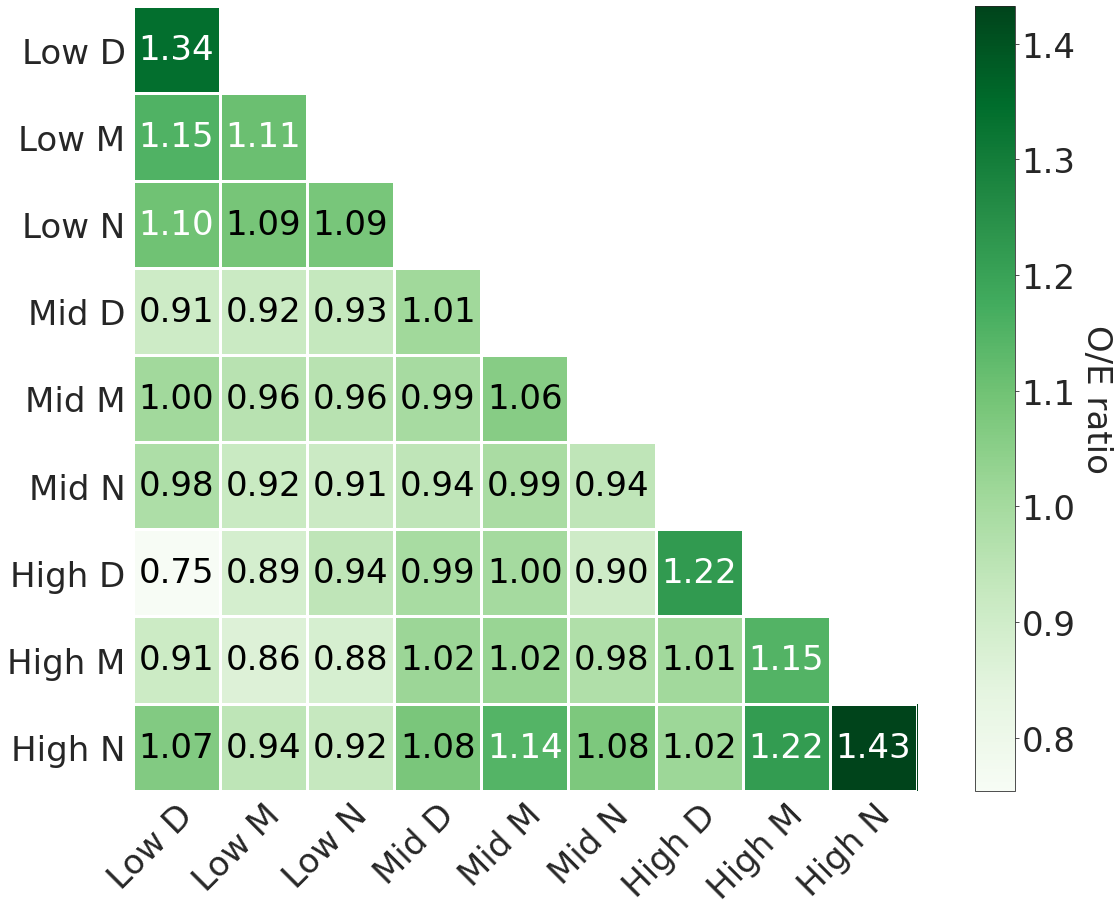

In [146]:
plt.rcParams.update({'figure.figsize' : (18,13.5), 'font.size': 34})
indices = ['Low diversity', 'Low mainstreaminess', 'Low novelty', 'Medium diversity', 'Medium mainstreaminess', 'Medium novelty', 'High diversity', 'High mainstreaminess', 'High novelty']
indices_short = ['Low D', 'Low M', 'Low N', 'Mid D', 'Mid M', 'Mid N', 'High D', 'High M', 'High N']

# indices = ['Diversity low', 'Mainstreaminess low', 'Novelty low', 'Diversity medium', 'Mainstreaminess medium', 'Novelty medium', 'Diversity high', 'Mainstreaminess high', 'Novelty high']
metric = 'real_expected_ratio'
values = np.zeros((len(indices), len(indices)))
for i in range(len(indices)):
    for j in range(len(indices)):
        if j > i:
            values[i,j] = np.nan
        else:
            values[i,j] = results[(indices[i], indices[j])][metric]
# values = np.array([[1.33871,0.9094,0.7548],[0.9094, 1.01024,0.9921],[0.75481,0.9921,1.22287]])

fig, ax = plt.subplots()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

im, cbar = heatmap(values, indices_short, indices_short, ax=ax,
                   cmap="Greens", cbarlabel="O/E ratio",
                  title='')
texts = annotate_heatmap(im, valfmt="{x:.2f}")

fig.tight_layout()
plt.savefig('figures/homophily_all_user_groups.pdf',dpi=300, bbox_inches = "tight")
plt.show()

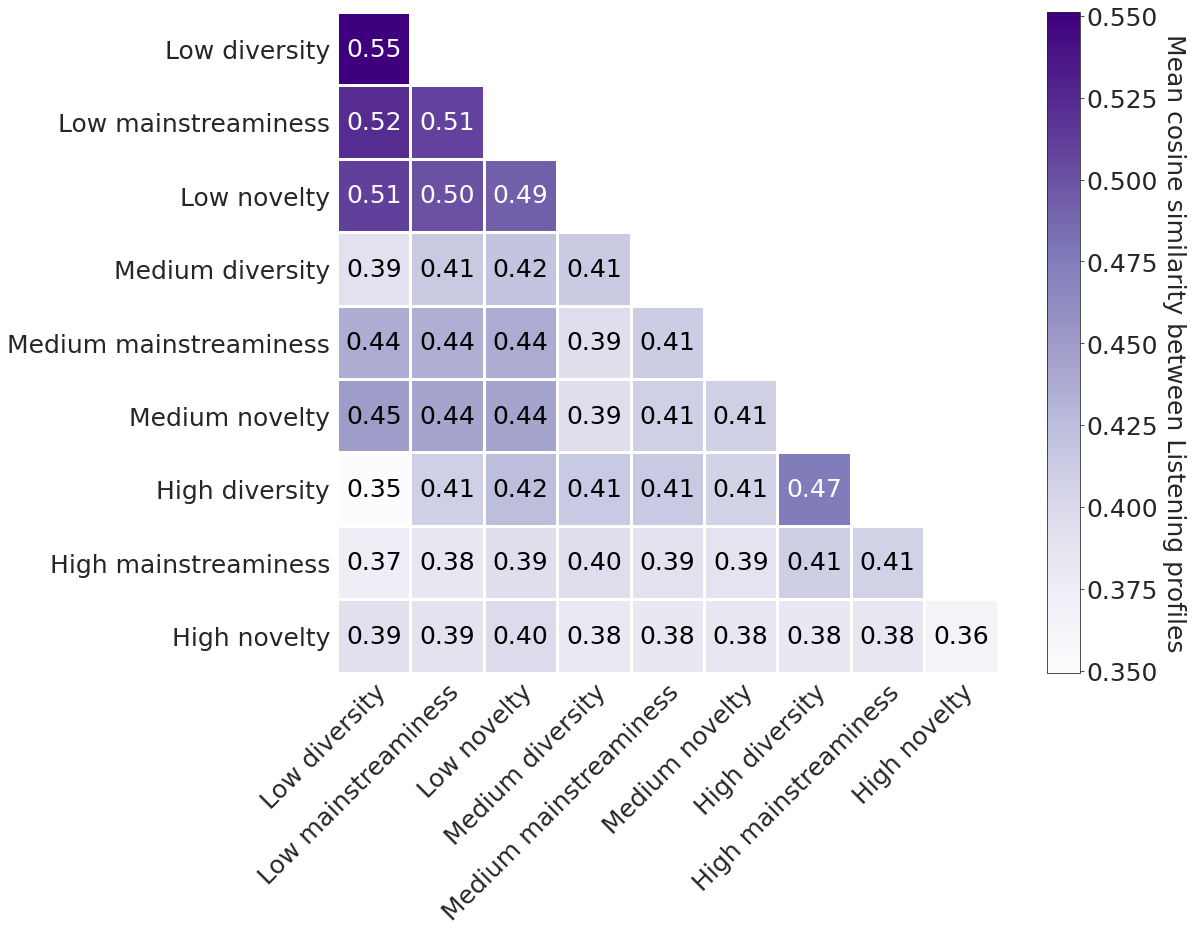

In [38]:
indices = ['Low diversity', 'Low mainstreaminess', 'Low novelty', 'Medium diversity', 'Medium mainstreaminess', 'Medium novelty', 'High diversity', 'High mainstreaminess', 'High novelty']
# indices = ['Diversity low', 'Mainstreaminess low', 'Novelty low', 'Diversity medium', 'Mainstreaminess medium', 'Novelty medium', 'Diversity high', 'Mainstreaminess high', 'Novelty high']
metric = 'cosine_similarity_UAM_nmf_mean'
# cosine_similarity_freebase_nmf_mean
# cosine_similarity_allmusic_mean
# cosine_similarity_UAM_nmf_mean
values = np.zeros((len(indices), len(indices)))
for i in range(len(indices)):
    for j in range(len(indices)):
        if j > i:
            values[i,j] = np.nan
        else:
            values[i,j] = results[(indices[i], indices[j])][metric]
# values = np.array([[1.33871,0.9094,0.7548],[0.9094, 1.01024,0.9921],[0.75481,0.9921,1.22287]])

fig, ax = plt.subplots()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

im, cbar = heatmap(values, indices, indices, ax=ax,
                   cmap="Purples", cbarlabel="Mean cosine similarity between Listening profiles",
                  title='')
texts = annotate_heatmap(im, valfmt="{x:.2f}")

fig.tight_layout()
plt.savefig('figures/UAM_nmf_mean_cosine_all_user_groups.pdf',dpi=300, bbox_inches = "tight")
plt.show()

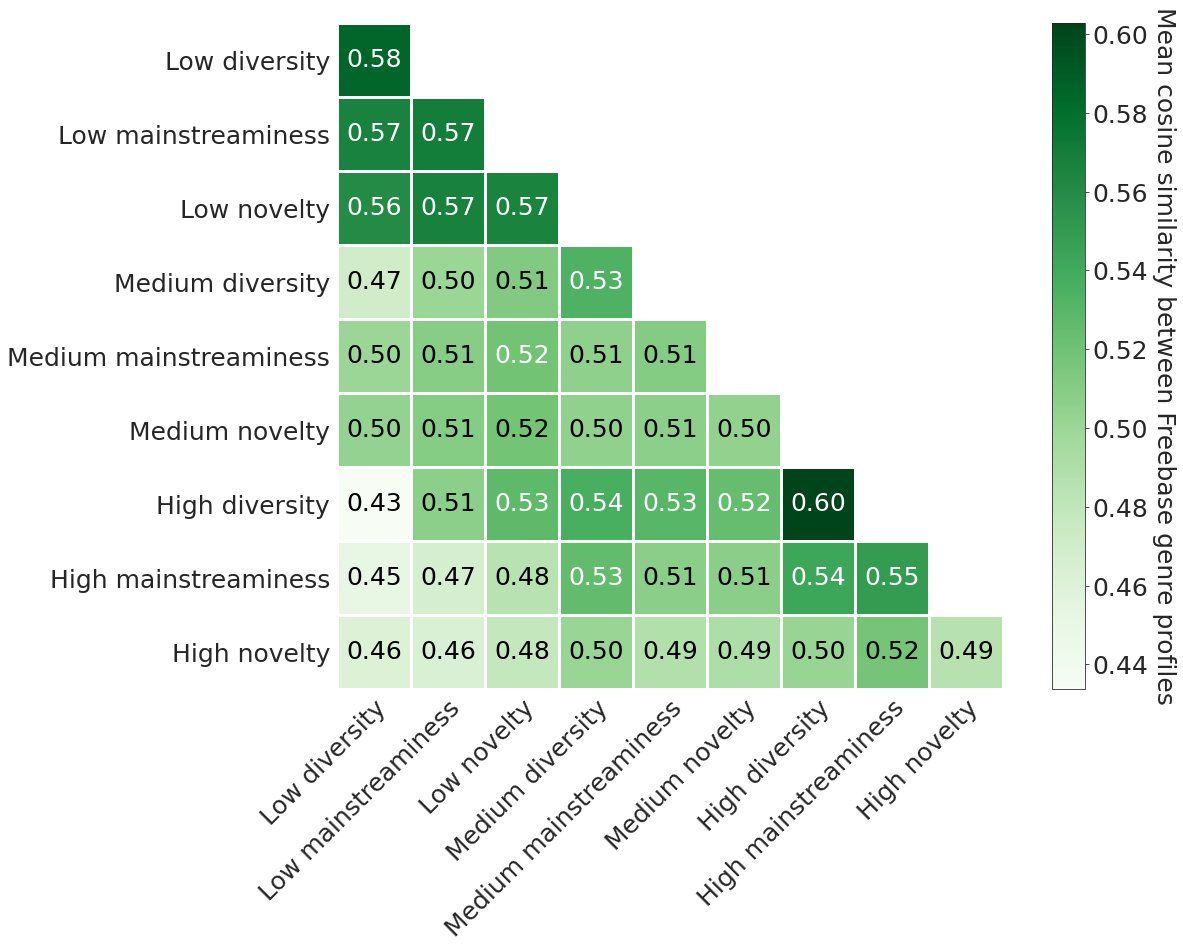

In [39]:
indices = ['Low diversity', 'Low mainstreaminess', 'Low novelty', 'Medium diversity', 'Medium mainstreaminess', 'Medium novelty', 'High diversity', 'High mainstreaminess', 'High novelty']
# indices = ['Diversity low', 'Mainstreaminess low', 'Novelty low', 'Diversity medium', 'Mainstreaminess medium', 'Novelty medium', 'Diversity high', 'Mainstreaminess high', 'Novelty high']
metric = 'cosine_similarity_freebase_nmf_mean'
# cosine_similarity_freebase_nmf_mean
# cosine_similarity_allmusic_mean
values = np.zeros((len(indices), len(indices)))
for i in range(len(indices)):
    for j in range(len(indices)):
        if j > i:
            values[i,j] = np.nan
        else:
            values[i,j] = results[(indices[i], indices[j])][metric]
# values = np.array([[1.33871,0.9094,0.7548],[0.9094, 1.01024,0.9921],[0.75481,0.9921,1.22287]])

fig, ax = plt.subplots()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

im, cbar = heatmap(values, indices, indices, ax=ax,
                   cmap="Greens", cbarlabel="Mean cosine similarity between Freebase genre profiles",
                  title='')
texts = annotate_heatmap(im, valfmt="{x:.2f}")

fig.tight_layout()
plt.savefig('figures/freebase_genre_cosine_all_user_groups.pdf',dpi=300, bbox_inches = "tight")
plt.show()

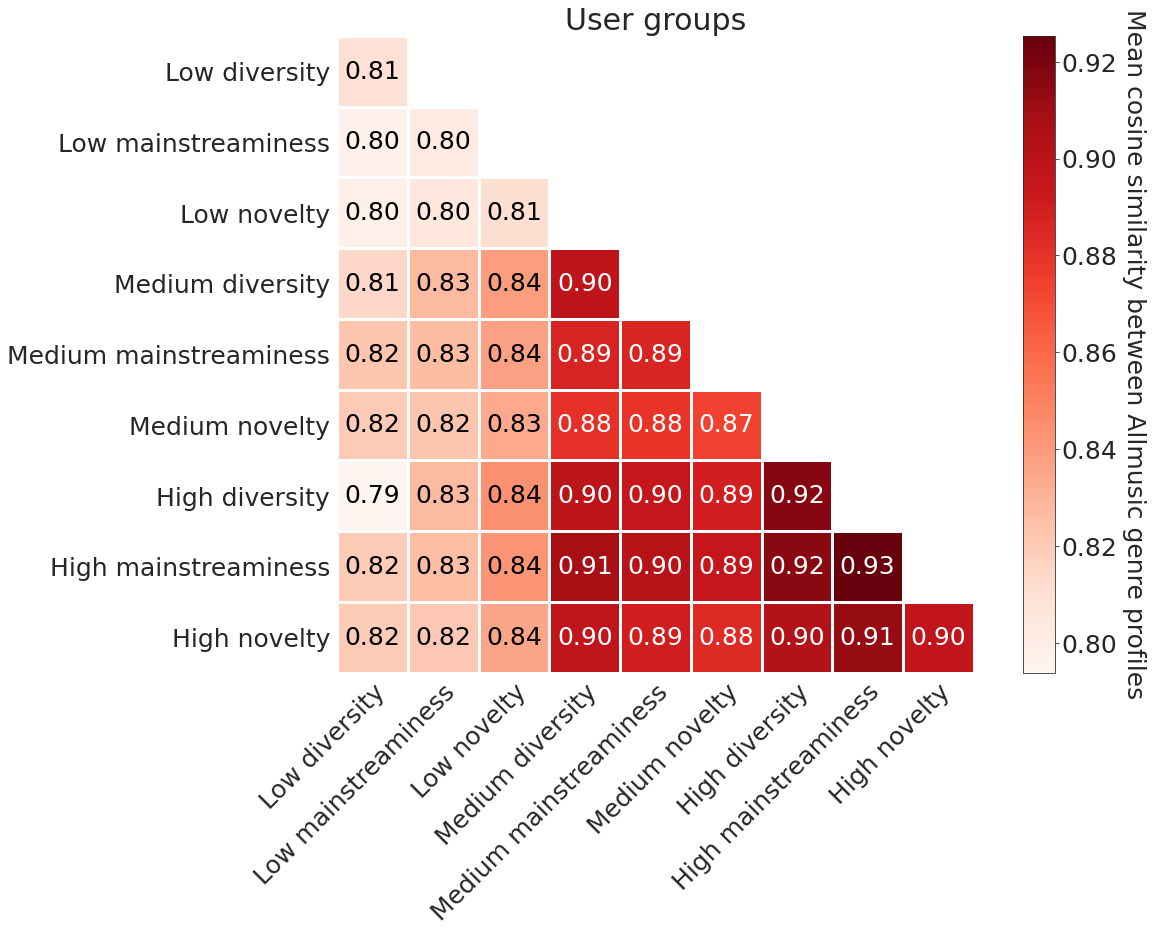

In [40]:
indices = ['Low diversity', 'Low mainstreaminess', 'Low novelty', 'Medium diversity', 'Medium mainstreaminess', 'Medium novelty', 'High diversity', 'High mainstreaminess', 'High novelty']
# indices = ['Diversity low', 'Mainstreaminess low', 'Novelty low', 'Diversity medium', 'Mainstreaminess medium', 'Novelty medium', 'Diversity high', 'Mainstreaminess high', 'Novelty high']
metric = 'cosine_similarity_allmusic_mean'
# cosine_similarity_freebase_nmf_mean
# cosine_similarity_allmusic_mean
values = np.zeros((len(indices), len(indices)))
for i in range(len(indices)):
    for j in range(len(indices)):
        if j > i:
            values[i,j] = np.nan
        else:
            values[i,j] = results[(indices[i], indices[j])][metric]
# values = np.array([[1.33871,0.9094,0.7548],[0.9094, 1.01024,0.9921],[0.75481,0.9921,1.22287]])

fig, ax = plt.subplots()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

im, cbar = heatmap(values, indices, indices, ax=ax,
                   cmap="Reds", cbarlabel="Mean cosine similarity between Allmusic genre profiles",
                  title='User groups')
texts = annotate_heatmap(im, valfmt="{x:.2f}")

fig.tight_layout()
plt.savefig('figures/allmusic_genre_cosine_all_user_groups.pdf',dpi=300, bbox_inches = "tight")
plt.show()

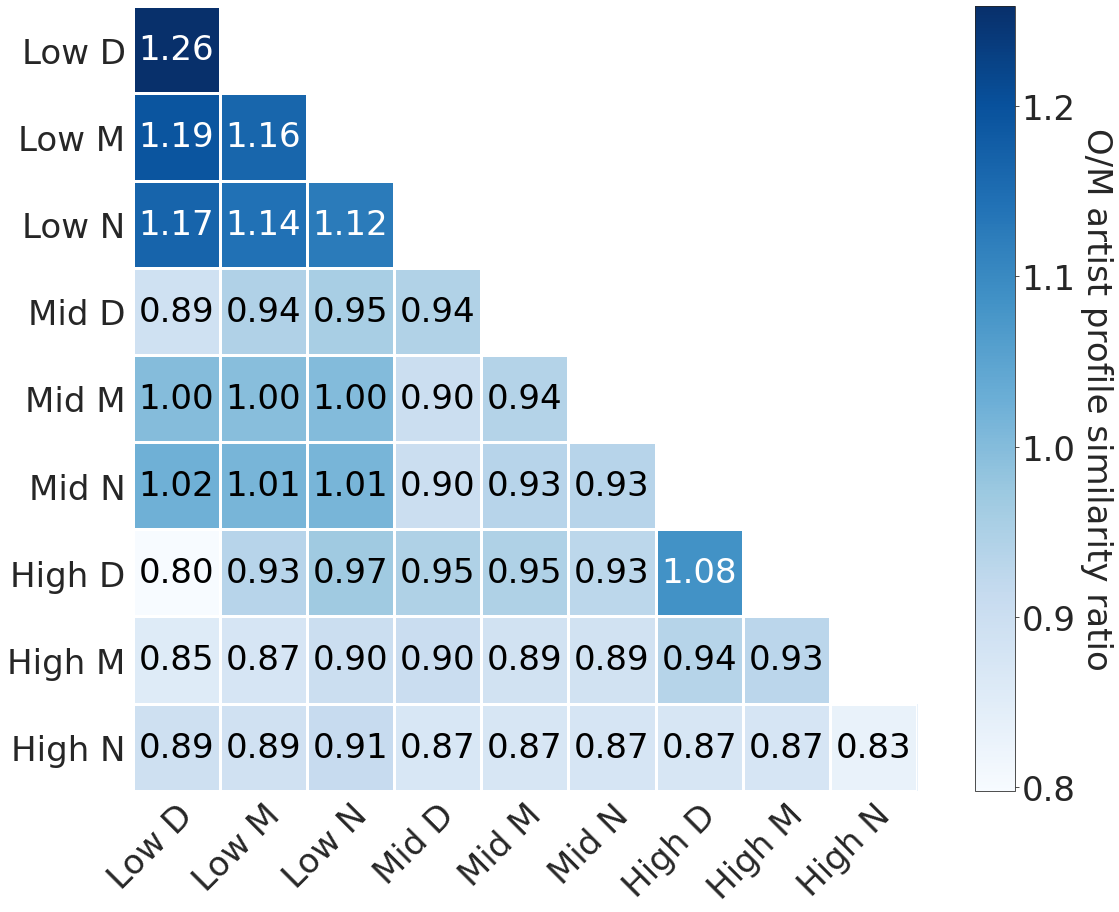

In [35]:
plt.rcParams.update({'figure.figsize' : (18,13.5), 'font.size': 34})
indices = ['Low diversity', 'Low mainstreaminess', 'Low novelty', 'Medium diversity', 'Medium mainstreaminess', 'Medium novelty', 'High diversity', 'High mainstreaminess', 'High novelty']
indices_short = ['Low D', 'Low M', 'Low N', 'Mid D', 'Mid M', 'Mid N', 'High D', 'High M', 'High N']
metric = 'cosine_similarity_UAM_nmf_diff_to_mean'
values = np.zeros((len(indices), len(indices)))
for i in range(len(indices)):
    for j in range(len(indices)):
        if j > i:
            values[i,j] = np.nan
        else:
            values[i,j] = results[(indices[i], indices[j])][metric]
# values = np.array([[1.33871,0.9094,0.7548],[0.9094, 1.01024,0.9921],[0.75481,0.9921,1.22287]])

fig, ax = plt.subplots()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

im, cbar = heatmap(values, indices_short, indices_short, ax=ax,
                   cmap="Blues", cbarlabel="O/M artist profile similarity ratio")
texts = annotate_heatmap(im, valfmt="{x:.2f}")

fig.tight_layout()
plt.savefig('figures/UAM_nmf_mean_cosine_all_user_groups_ratio.pdf',dpi=300, bbox_inches = "tight")
plt.show()

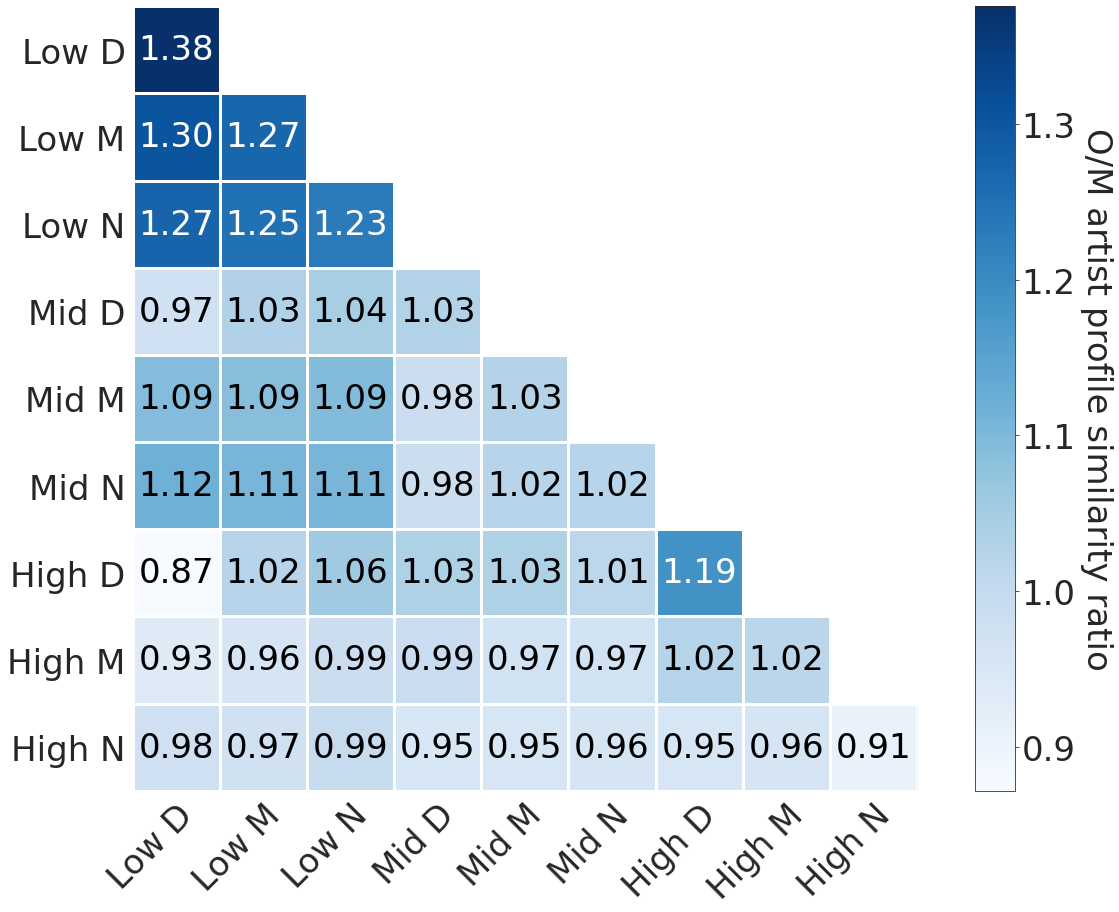

In [38]:
plt.rcParams.update({'figure.figsize' : (18,13.5), 'font.size': 34})
indices = ['Low diversity', 'Low mainstreaminess', 'Low novelty', 'Medium diversity', 'Medium mainstreaminess', 'Medium novelty', 'High diversity', 'High mainstreaminess', 'High novelty']
indices_short = ['Low D', 'Low M', 'Low N', 'Mid D', 'Mid M', 'Mid N', 'High D', 'High M', 'High N']
metric = 'cosine_similarity_UAM_nmf_diff_to_median'
values = np.zeros((len(indices), len(indices)))
for i in range(len(indices)):
    for j in range(len(indices)):
        if j > i:
            values[i,j] = np.nan
        else:
            values[i,j] = results[(indices[i], indices[j])][metric]
# values = np.array([[1.33871,0.9094,0.7548],[0.9094, 1.01024,0.9921],[0.75481,0.9921,1.22287]])

fig, ax = plt.subplots()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

im, cbar = heatmap(values, indices_short, indices_short, ax=ax,
                   cmap="Blues", cbarlabel="O/M artist profile similarity ratio")
texts = annotate_heatmap(im, valfmt="{x:.2f}")

fig.tight_layout()
plt.savefig('figures/UAM_nmf_median_cosine_all_user_groups_ratio.pdf',dpi=300, bbox_inches = "tight")
plt.show()

In [42]:
degrees = [d for v, d in G.degree()]
G_conf=nx.configuration_model(degrees)
G_conf=nx.Graph(G_conf)
G_conf.remove_edges_from(nx.selfloop_edges(G_conf))

node_ids = list(G.nodes)
source_nodes_conf = []
target_nodes_conf = []
for edge in G_conf.edges:
    source_nodes_conf.append(node_ids[edge[0]])
    target_nodes_conf.append(node_ids[edge[1]])

In [43]:
user1_df = pd.DataFrame(source_nodes_conf).rename(columns={0:'user_id'}).merge(users_df[['user_id', 'UAM_nmf_array', 'freebase_nmf_array']], on='user_id', how='left').rename(columns={'user_id':'user1_user_id', 'UAM_nmf_array':'user1_UAM_nmf_array', 'freebase_nmf_array':'user1_freebase_array'})
user2_df = pd.DataFrame(target_nodes_conf).rename(columns={0:'user_id'}).merge(users_df[['user_id', 'UAM_nmf_array', 'freebase_nmf_array']], on='user_id', how='left').rename(columns={'user_id':'user2_user_id', 'UAM_nmf_array':'user2_UAM_nmf_array', 'freebase_nmf_array':'user2_freebase_array'})

In [44]:
profile_similarity_conf_df = pd.concat([user1_df, user2_df], axis=1)
profile_similarity_conf_df['cosine_similarity_'+'UAM_nmf_array'] = profile_similarity_conf_df.apply(lambda x: cosine_similarity(x['user1_'+'UAM_nmf_array'], x['user2_'+'UAM_nmf_array']), axis=1)
profile_similarity_conf_df['cosine_similarity_'+'freebase_array'] = profile_similarity_conf_df.apply(lambda x: cosine_similarity(x['user1_'+'freebase_array'], x['user2_'+'freebase_array']), axis=1)

In [45]:
# plt.rcParams.update({'figure.figsize' : (8,5), 'font.size': 18})
# sns.distplot(pd.Series(df_subset['cosine_similarity_UAM_nmf_array'].values, name='Listening profile similarity'), color='blue', label='Existing edges', kde=False, norm_hist=False)
# # sns.distplot(profile_similarity_conf_df['cosine_similarity_UAM_nmf_array'].values, color='purple', label='Random edges (preserving D)', kde=True, norm_hist=False)
# sns.distplot(links_shuffled_mul_df['cosine_similarity_UAM_nmf_array'].values, color='black', label='Randomly rewired edges', kde=False, norm_hist=False)
# plt.xlim(0, 1.0)
# plt.legend();
# plt.savefig('figures/existing_vs_random_listening_profile_similarity.pdf',dpi=300, bbox_inches = "tight")
print(df_subset['cosine_similarity_UAM_nmf_array'].mean())
print(df_subset['cosine_similarity_UAM_nmf_array'].std())
print(links_shuffled_mul_df['cosine_similarity_UAM_nmf_array'].mean())
print(links_shuffled_mul_df['cosine_similarity_UAM_nmf_array'].std())

0.4379050234191874
0.3138664792944398


NameError: name 'links_shuffled_mul_df' is not defined

/home/tduricic/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


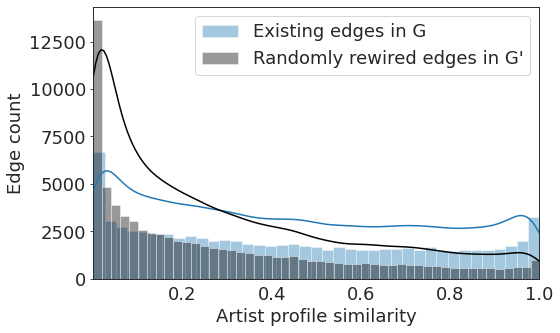

In [52]:
plt.rcParams.update({'figure.figsize' : (8,5), 'font.size': 18})
f,ax1 = plt.subplots()
sns.distplot(df_subset['cosine_similarity_UAM_nmf_array'].values,kde=False,ax=ax1, label='Existing edges in G')
sns.distplot(links_shuffled_mul_df['cosine_similarity_UAM_nmf_array'].values,kde=False,ax=ax1, label='Randomly rewired edges in G\'', color='black')
plt.legend();
ax2 = ax1.twinx()
ax2.set_ylim(0,4)
ax2.yaxis.set_ticks([])
sns.kdeplot(df_subset['cosine_similarity_UAM_nmf_array'].values,ax=ax2)
sns.kdeplot(links_shuffled_mul_df['cosine_similarity_UAM_nmf_array'].values,ax=ax2, color='black')
ax1.set_xlabel('Artist profile similarity')
ax1.set_ylabel('Edge count')
ax2.set_xticks([0.2,0.4,0.6,0.8,1])
# ax.set_xticklabels(['zero','two','four','six'])
plt.xlim(0, 1.0)
plt.savefig('figures/existing_vs_random_listening_profile_similarity.pdf',dpi=300, bbox_inches = "tight")

/home/tduricic/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


NameError: name 'profile_similarity_df' is not defined

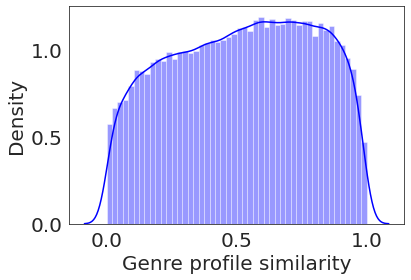

In [9]:
sns.distplot(pd.Series(df_subset['cosine_similarity_freebase_nmf_array'].values, name='Genre profile similarity'), color='blue', label='Existing edges', kde=True, norm_hist=True)
sns.distplot(profile_similarity_df['cosine_similarity_freebase_array'].values, color='black', label='Randomly rewired edges', kde=True, norm_hist=True)
plt.xlim(0, 1.0)
plt.legend();
plt.savefig('figures/existing_vs_random_genre_profile_similarity.pdf',dpi=300, bbox_inches = "tight")
print(df_subset['cosine_similarity_freebase_nmf_array'].mean())
print(df_subset['cosine_similarity_freebase_nmf_array'].std())
print(profile_similarity_df['cosine_similarity_freebase_array'].mean())
print(profile_similarity_df['cosine_similarity_freebase_array'].std())

In [47]:
# Create dataframe for the configuration model and create plots for that
users1_conf_df = pd.DataFrame([x for x in source_nodes_conf]).rename(columns={0:'user_id'}).merge(users_df, how='left', on='user_id').add_prefix('user1_')
users2_conf_df = pd.DataFrame([x for x in target_nodes_conf]).rename(columns={0:'user_id'}).merge(users_df, how='left', on='user_id').add_prefix('user2_')
links_conf_df = pd.concat([users1_conf_df, users2_conf_df.set_index(users1_conf_df.index)], axis=1)
links_conf_df['cosine_similarity_'+'UAM_nmf_array'] = links_conf_df.apply(lambda x: cosine_similarity(x['user1_'+'UAM_nmf_array'], x['user2_'+'UAM_nmf_array']), axis=1)
links_conf_df['cosine_similarity_'+'freebase_nmf_array'] = links_conf_df.apply(lambda x: cosine_similarity(x['user1_'+'freebase_nmf_array'], x['user2_'+'freebase_nmf_array']), axis=1)
links_conf_df['label'] = 1
links_conf_df = calculate_cosine_similarity_for_vector_features(links_conf_df, ['allmusic_genre_array', 'freebase_nmf_array', 'UAM_nmf_array'])

In [449]:
namings_map = {
    'mainstreaminess_global':'mainstreaminess',
    'freebase_weighted_average_diversity':'diversity',
    'novelty_artist_avg_6months':'novelty'
}
keys = ['mainstreaminess_global|high', 
        'mainstreaminess_global|medium', 
        'mainstreaminess_global|low',
        'freebase_weighted_average_diversity|high',
        'freebase_weighted_average_diversity|medium',
        'freebase_weighted_average_diversity|low',
        'novelty_artist_avg_6months|high',
        'novelty_artist_avg_6months|medium',
        'novelty_artist_avg_6months|low']
results_conf = {}
for key1 in keys:
    for key2 in keys:
        metric1 = key1.split('|')[0]
        user_group1 = key1.split('|')[1]
        metric2 = key2.split('|')[0]
        user_group2 = key2.split('|')[1]
        if key1 == key2:
            expected_edges = (nodes_per_group[metric1][user_group1]/total_nodes)*(nodes_per_group[metric2][user_group2]/total_nodes) * total_edges
            real_edges = len(links_conf_df[(links_conf_df['user1_user_groups_'+metric1+'_'+user_group1]==True)&((links_conf_df['user2_user_groups_'+metric2+'_'+user_group2]==True))])
            cosine_similarity_allmusic_genre_array_values = links_conf_df[(links_conf_df['user1_user_groups_'+metric1+'_'+user_group1]==True)&((links_conf_df['user2_user_groups_'+metric2+'_'+user_group2]==True))].cosine_similarity_allmusic_genre_array.values
            cosine_similarity_freebase_nmf_array_values = links_conf_df[(links_conf_df['user1_user_groups_'+metric1+'_'+user_group1]==True)&((links_conf_df['user2_user_groups_'+metric2+'_'+user_group2]==True))].cosine_similarity_freebase_nmf_array.values
            cosine_similarity_UAM_nmf_array_values = links_conf_df[(links_conf_df['user1_user_groups_'+metric1+'_'+user_group1]==True)&((links_conf_df['user2_user_groups_'+metric2+'_'+user_group2]==True))].cosine_similarity_UAM_nmf_array.values
        else:
            expected_edges = 2*(nodes_per_group[metric1][user_group1]/total_nodes)*(nodes_per_group[metric2][user_group2]/total_nodes) * total_edges
            real_edges = len(links_conf_df[(links_conf_df['user1_user_groups_'+metric1+'_'+user_group1]==True)&((links_conf_df['user2_user_groups_'+metric2+'_'+user_group2]==True))]) + len(links_conf_df[(links_conf_df['user1_user_groups_'+metric2+'_'+user_group2]==True)&((links_conf_df['user2_user_groups_'+metric1+'_'+user_group1]==True))])
            cosine_similarity_allmusic_genre_array_values = np.concatenate([links_conf_df[(links_conf_df['user1_user_groups_'+metric1+'_'+user_group1]==True)&((links_conf_df['user2_user_groups_'+metric2+'_'+user_group2]==True))].cosine_similarity_allmusic_genre_array.values, links_conf_df[(links_conf_df['user1_user_groups_'+metric2+'_'+user_group2]==True)&((links_conf_df['user2_user_groups_'+metric1+'_'+user_group1]==True))].cosine_similarity_allmusic_genre_array.values])
            cosine_similarity_freebase_nmf_array_values = np.concatenate([links_conf_df[(links_conf_df['user1_user_groups_'+metric1+'_'+user_group1]==True)&((links_conf_df['user2_user_groups_'+metric2+'_'+user_group2]==True))].cosine_similarity_freebase_nmf_array.values, links_conf_df[(links_conf_df['user1_user_groups_'+metric2+'_'+user_group2]==True)&((links_conf_df['user2_user_groups_'+metric1+'_'+user_group1]==True))].cosine_similarity_freebase_nmf_array.values])
            cosine_similarity_UAM_nmf_array_values = np.concatenate([links_conf_df[(links_conf_df['user1_user_groups_'+metric1+'_'+user_group1]==True)&((links_conf_df['user2_user_groups_'+metric2+'_'+user_group2]==True))].cosine_similarity_UAM_nmf_array.values, links_conf_df[(links_conf_df['user1_user_groups_'+metric2+'_'+user_group2]==True)&((links_conf_df['user2_user_groups_'+metric1+'_'+user_group1]==True))].cosine_similarity_UAM_nmf_array.values])
        results_key1 = user_group1.capitalize() + ' ' + namings_map[metric1]
        results_key2 = user_group2.capitalize() + ' ' + namings_map[metric2]
        results_conf[(results_key1,results_key2)] = {
            'expected_edges':expected_edges, 
            'real_edges':real_edges, 
            'real_expected_ratio': real_edges/expected_edges,
            'cosine_similarity_allmusic_mean':np.nanmean(cosine_similarity_allmusic_genre_array_values),
            'cosine_similarity_freebase_nmf_mean':np.nanmean(cosine_similarity_freebase_nmf_array_values),
            'cosine_similarity_UAM_nmf_mean':np.nanmean(cosine_similarity_UAM_nmf_array_values),
            'cosine_similarity_allmusic_diff_to_mean':np.nanmean(cosine_similarity_allmusic_genre_array_values)/np.nanmean(links_conf_df.cosine_similarity_allmusic_genre_array),
            'cosine_similarity_freebase_diff_to_mean':np.nanmean(cosine_similarity_freebase_nmf_array_values)/np.nanmean(links_conf_df.cosine_similarity_freebase_nmf_array),
            'cosine_similarity_UAM_nmf_diff_to_mean':np.nanmean(cosine_similarity_UAM_nmf_array_values)/np.nanmean(links_conf_df.cosine_similarity_UAM_nmf_array)
        }

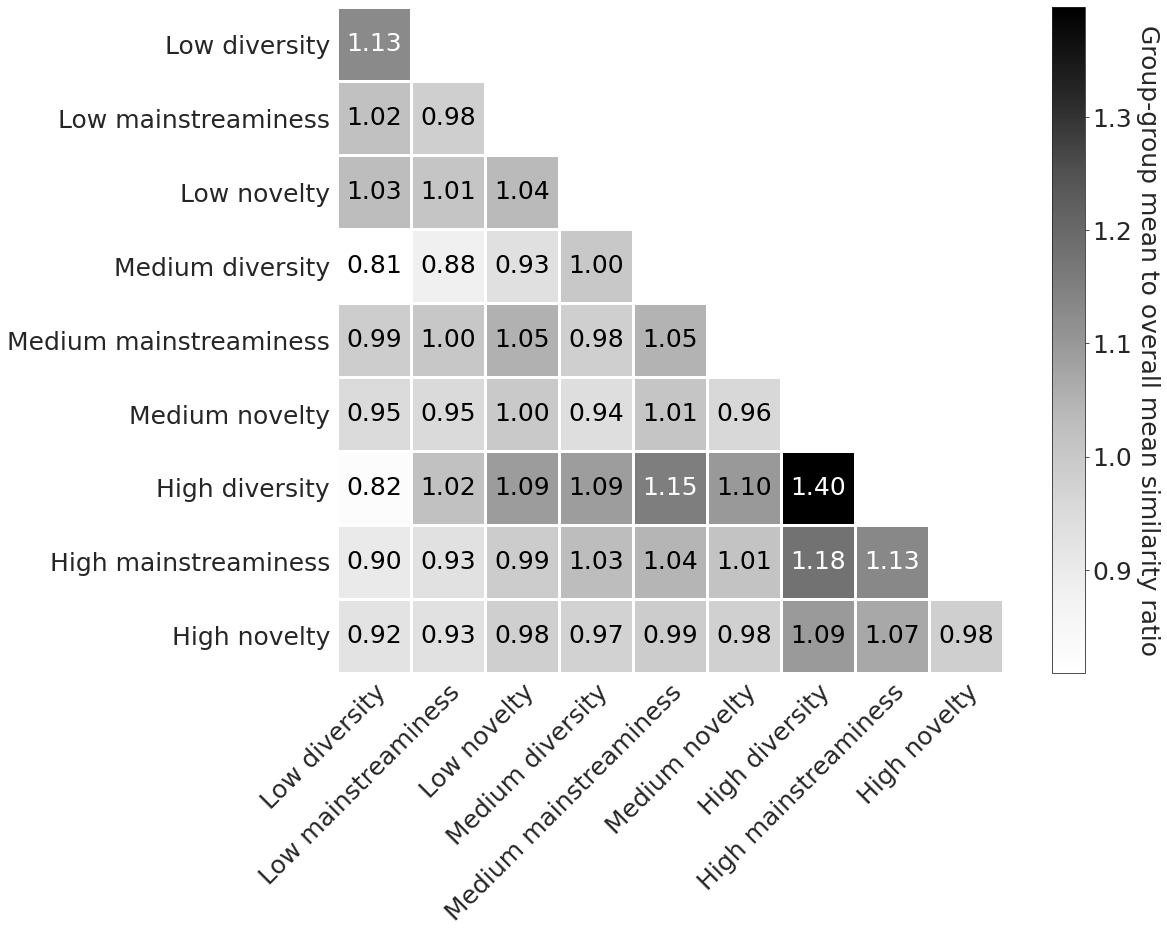

In [522]:
plt.rcParams.update({'figure.figsize' : (18,13.5), 'font.size': 25})
indices = ['Low diversity', 'Low mainstreaminess', 'Low novelty', 'Medium diversity', 'Medium mainstreaminess', 'Medium novelty', 'High diversity', 'High mainstreaminess', 'High novelty']
# metric = 'real_expected_ratio'
# metric = 'cosine_similarity_UAM_nmf_mean'
metric = 'cosine_similarity_UAM_nmf_diff_to_mean'
values = np.zeros((len(indices), len(indices)))
for i in range(len(indices)):
    for j in range(len(indices)):
        if j > i:
            values[i,j] = np.nan
        else:
            # results_conf
            values[i,j] = results_shuffled_mul[(indices[i], indices[j])][metric]

fig, ax = plt.subplots()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# im, cbar = heatmap(values, indices, indices, ax=ax,
#                    cmap="Blues", cbarlabel="Existing/expected edges ratio",
#                   title='')
# im, cbar = heatmap(values, indices, indices, ax=ax,
#                    cmap="Purples", cbarlabel="Mean cosine similarity between Listening profiles",
#                   title='')
im, cbar = heatmap(values, indices, indices, ax=ax,
                   cmap="Greys", cbarlabel="Group-group mean to overall mean similarity ratio")

texts = annotate_heatmap(im, valfmt="{x:.2f}")

fig.tight_layout()
# plt.savefig('figures/shuffled_mul_homophily_all_user_groups.pdf',dpi=300, bbox_inches = "tight")
# plt.savefig('figures/shuffled_mul_UAM_nmf_mean_cosine_all_user_groups.pdf',dpi=300, bbox_inches = "tight")
plt.savefig('figures/shuffled_mul_UAM_nmf_mean_cosine_all_user_groups_ratio.pdf',dpi=300, bbox_inches = "tight")

plt.show()

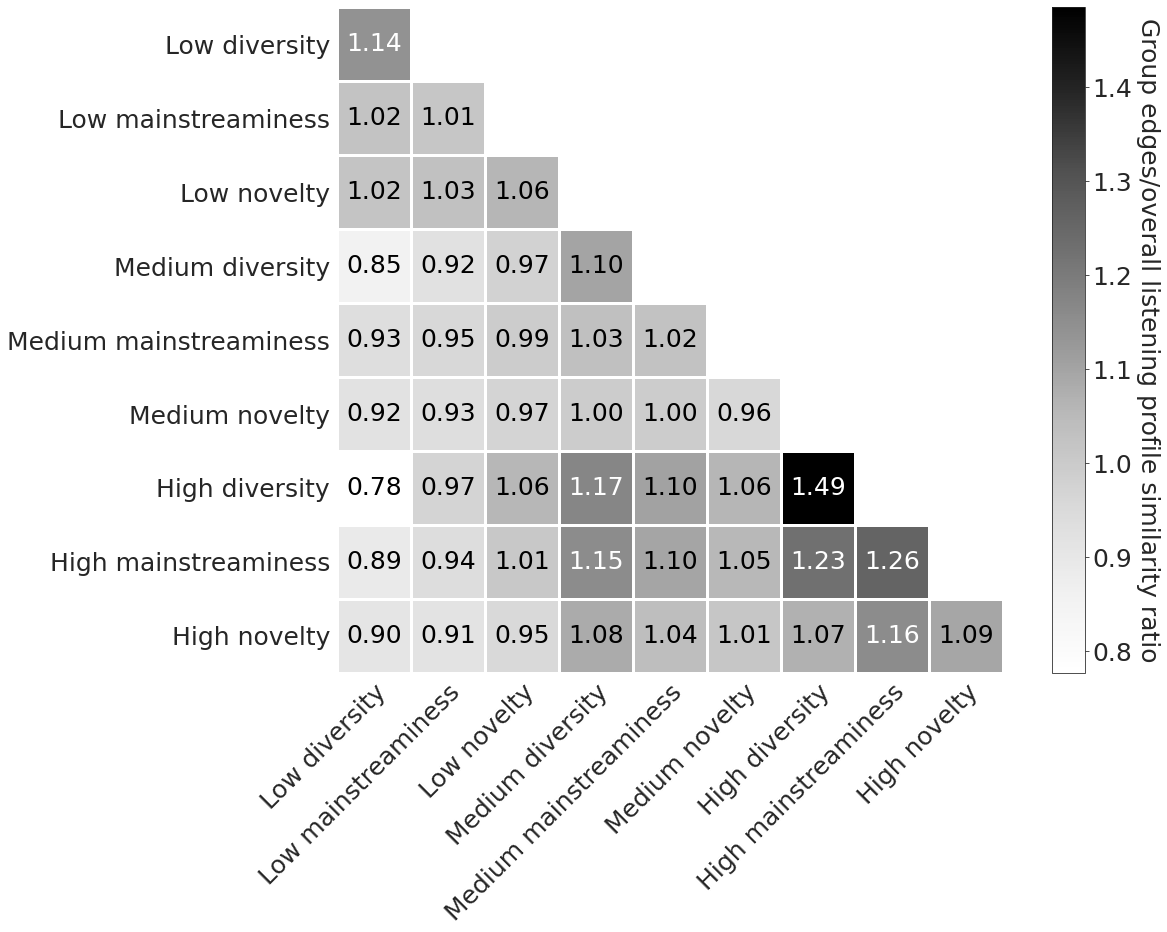

In [372]:
plt.rcParams.update({'figure.figsize' : (18,13.5), 'font.size': 25})
indices = ['Low diversity', 'Low mainstreaminess', 'Low novelty', 'Medium diversity', 'Medium mainstreaminess', 'Medium novelty', 'High diversity', 'High mainstreaminess', 'High novelty']
# indices = ['Diversity low', 'Mainstreaminess low', 'Novelty low', 'Diversity medium', 'Mainstreaminess medium', 'Novelty medium', 'Diversity high', 'Mainstreaminess high', 'Novelty high']
metric = 'cosine_similarity_UAM_nmf_diff_to_mean'
# cosine_similarity_freebase_nmf_mean
# cosine_similarity_allmusic_mean
# cosine_similarity_UAM_nmf_mean
values = np.zeros((len(indices), len(indices)))
for i in range(len(indices)):
    for j in range(len(indices)):
        if j > i:
            values[i,j] = np.nan
        else:
            values[i,j] = results_conf[(indices[i], indices[j])][metric]
# values = np.array([[1.33871,0.9094,0.7548],[0.9094, 1.01024,0.9921],[0.75481,0.9921,1.22287]])

fig, ax = plt.subplots()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

im, cbar = heatmap(values, indices, indices, ax=ax,
                   cmap="Greys", cbarlabel="Group edges/overall listening profile similarity ratio",
                  title='')
texts = annotate_heatmap(im, valfmt="{x:.2f}")

fig.tight_layout()
# plt.savefig('figures/UAM_nmf_mean_cosine_all_user_groups.pdf',dpi=300, bbox_inches = "tight")
plt.show()

In [39]:
# Create random graph by preserving number of connections for multiple dimensions
edge_groups = {}

for index, row in links_df.groupby(['user1_user_groups_mainstreaminess_global', 
                  'user1_user_groups_novelty_artist_avg_6months', 
                  'user1_user_groups_freebase_weighted_average_diversity', 
                  'user2_user_groups_mainstreaminess_global', 
                  'user2_user_groups_novelty_artist_avg_6months', 
                  'user2_user_groups_freebase_weighted_average_diversity']).size().reset_index(name='Count').iterrows():
    edge_groups[((
        row['user1_user_groups_mainstreaminess_global'],
        row['user1_user_groups_novelty_artist_avg_6months'],
        row['user1_user_groups_freebase_weighted_average_diversity']
    ),(
        row['user2_user_groups_mainstreaminess_global'],
        row['user2_user_groups_novelty_artist_avg_6months'],
        row['user2_user_groups_freebase_weighted_average_diversity'],
    ))] = links_df[
        (links_df['user1_user_groups_mainstreaminess_global']==row['user1_user_groups_mainstreaminess_global'])&
        (links_df['user1_user_groups_novelty_artist_avg_6months']==row['user1_user_groups_novelty_artist_avg_6months'])&
        (links_df['user1_user_groups_freebase_weighted_average_diversity']==row['user1_user_groups_freebase_weighted_average_diversity'])&
        (links_df['user2_user_groups_mainstreaminess_global']==row['user2_user_groups_mainstreaminess_global'])&
        (links_df['user2_user_groups_novelty_artist_avg_6months']==row['user2_user_groups_novelty_artist_avg_6months'])&
        (links_df['user2_user_groups_freebase_weighted_average_diversity']==row['user2_user_groups_freebase_weighted_average_diversity'])
    ][['user1_user_id', 'user2_user_id']]
    
merged_edge_groups = {}
for key in edge_groups:
    if key in merged_edge_groups or ((key[1][0], key[1][1], key[1][2]), (key[0][0], key[0][1], key[0][2])) in merged_edge_groups:
        continue
    if ((key[1][0], key[1][1], key[1][2]), (key[0][0], key[0][1], key[0][2])) in edge_groups and (key[0][0], key[0][1], key[0][2]) != (key[1][0], key[1][1], key[1][2]):
        tmp_df = pd.DataFrame()
        tmp_df['user1_user_id'] = pd.Series(edge_groups[((key[1][0], key[1][1], key[1][2]), (key[0][0], key[0][1], key[0][2]))]['user2_user_id'])
        tmp_df['user2_user_id'] = pd.Series(edge_groups[((key[1][0], key[1][1], key[1][2]), (key[0][0], key[0][1], key[0][2]))]['user1_user_id'])
        merged_edge_groups[key] = edge_groups[key].append(tmp_df, ignore_index=True)
    else:
        merged_edge_groups[key] = edge_groups[key]
        
shuffled_edge_groups = {}
shuffled_links_mul_random_df = pd.DataFrame(columns=['user1_user_id', 'user2_user_id'])
for key in merged_edge_groups:
    tmp_df = pd.DataFrame(merged_edge_groups[key])
    user2_df = tmp_df.drop('user1_user_id', axis=1)
    user2_df = user2_df.sample(frac=1, random_state=0)
    tmp_df['user2_user_id'] = user2_df['user2_user_id'].values
    shuffled_edge_groups[key] = tmp_df
    shuffled_links_mul_random_df = shuffled_links_mul_random_df.append(tmp_df, ignore_index=True)

In [45]:
links_df[links_df.user1_user_id==34641085][['user1_user_id', 'user2_user_id']]

,user1_user_id,user2_user_id


In [44]:
shuffled_links_mul_random_df[shuffled_links_mul_random_df.user1_user_id==34641085][['user1_user_id', 'user2_user_id']]

,user1_user_id,user2_user_id
62935,34641085,3255714


In [108]:
shuffled_links_mul_random_df_9 = pd.DataFrame(shuffled_links_mul_random_df)

In [118]:
users1_shuffled_mul_df = pd.DataFrame([x for x in shuffled_links_mul_random_df_9.user1_user_id.values]).rename(columns={0:'user_id'}).merge(users_df, how='left', on='user_id').add_prefix('user1_')
users2_shuffled_mul_df = pd.DataFrame([x for x in shuffled_links_mul_random_df_9.user2_user_id.values]).rename(columns={0:'user_id'}).merge(users_df, how='left', on='user_id').add_prefix('user2_')
links_shuffled_mul_df_9 = pd.concat([users1_shuffled_mul_df, users2_shuffled_mul_df.set_index(users1_shuffled_mul_df.index)], axis=1)
links_shuffled_mul_df_9['label'] = 1
links_shuffled_mul_df_9 = calculate_cosine_similarity_for_vector_features(links_shuffled_mul_df_9, ['allmusic_genre_array', 'freebase_nmf_array', 'UAM_nmf_array'])

In [83]:
print(cosine_similarity_UAM_nmf_array_values)

[]


In [129]:
namings_map = {
    'mainstreaminess_global':'mainstreaminess',
    'freebase_weighted_average_diversity':'diversity',
    'novelty_artist_avg_6months':'novelty'
}
keys = ['mainstreaminess_global|high', 
        'mainstreaminess_global|medium', 
        'mainstreaminess_global|low',
        'freebase_weighted_average_diversity|high',
        'freebase_weighted_average_diversity|medium',
        'freebase_weighted_average_diversity|low',
        'novelty_artist_avg_6months|high',
        'novelty_artist_avg_6months|medium',
        'novelty_artist_avg_6months|low']
results_shuffled_mul_9 = {}
for key1 in keys:
    for key2 in keys:
        metric1 = key1.split('|')[0]
        user_group1 = key1.split('|')[1]
        metric2 = key2.split('|')[0]
        user_group2 = key2.split('|')[1]
        if key1 == key2:
            expected_edges = (nodes_per_group[metric1][user_group1]/total_nodes)*(nodes_per_group[metric2][user_group2]/total_nodes) * total_edges
            real_edges = len(links_shuffled_mul_df_9[(links_shuffled_mul_df_9['user1_user_groups_'+metric1+'_'+user_group1]==True)&((links_shuffled_mul_df_9['user2_user_groups_'+metric2+'_'+user_group2]==True))])
            cosine_similarity_allmusic_genre_array_values = links_shuffled_mul_df_9[(links_shuffled_mul_df_9['user1_user_groups_'+metric1+'_'+user_group1]==True)&((links_shuffled_mul_df_9['user2_user_groups_'+metric2+'_'+user_group2]==True))].cosine_similarity_allmusic_genre_array.values
            cosine_similarity_freebase_nmf_array_values = links_shuffled_mul_df_9[(links_shuffled_mul_df_9['user1_user_groups_'+metric1+'_'+user_group1]==True)&((links_shuffled_mul_df_9['user2_user_groups_'+metric2+'_'+user_group2]==True))].cosine_similarity_freebase_nmf_array.values
            cosine_similarity_UAM_nmf_array_values = links_shuffled_mul_df_9[(links_shuffled_mul_df_9['user1_user_groups_'+metric1+'_'+user_group1]==True)&((links_shuffled_mul_df_9['user2_user_groups_'+metric2+'_'+user_group2]==True))].cosine_similarity_UAM_nmf_array.values
        else:
            expected_edges = 2*(nodes_per_group[metric1][user_group1]/total_nodes)*(nodes_per_group[metric2][user_group2]/total_nodes) * total_edges
            real_edges = len(links_shuffled_mul_df_9[(links_shuffled_mul_df_9['user1_user_groups_'+metric1+'_'+user_group1]==True)&((links_shuffled_mul_df_9['user2_user_groups_'+metric2+'_'+user_group2]==True))]) + len(links_shuffled_mul_df_9[(links_shuffled_mul_df_9['user1_user_groups_'+metric2+'_'+user_group2]==True)&((links_shuffled_mul_df_9['user2_user_groups_'+metric1+'_'+user_group1]==True))])
            cosine_similarity_allmusic_genre_array_values = np.concatenate([links_shuffled_mul_df_9[(links_shuffled_mul_df_9['user1_user_groups_'+metric1+'_'+user_group1]==True)&((links_shuffled_mul_df_9['user2_user_groups_'+metric2+'_'+user_group2]==True))].cosine_similarity_allmusic_genre_array.values, links_shuffled_mul_df_9[(links_shuffled_mul_df_9['user1_user_groups_'+metric2+'_'+user_group2]==True)&((links_shuffled_mul_df_9['user2_user_groups_'+metric1+'_'+user_group1]==True))].cosine_similarity_allmusic_genre_array.values])
            cosine_similarity_freebase_nmf_array_values = np.concatenate([links_shuffled_mul_df_9[(links_shuffled_mul_df_9['user1_user_groups_'+metric1+'_'+user_group1]==True)&((links_shuffled_mul_df_9['user2_user_groups_'+metric2+'_'+user_group2]==True))].cosine_similarity_freebase_nmf_array.values, links_shuffled_mul_df_9[(links_shuffled_mul_df_9['user1_user_groups_'+metric2+'_'+user_group2]==True)&((links_shuffled_mul_df_9['user2_user_groups_'+metric1+'_'+user_group1]==True))].cosine_similarity_freebase_nmf_array.values])
            cosine_similarity_UAM_nmf_array_values = np.concatenate([links_shuffled_mul_df_9[(links_shuffled_mul_df_9['user1_user_groups_'+metric1+'_'+user_group1]==True)&((links_shuffled_mul_df_9['user2_user_groups_'+metric2+'_'+user_group2]==True))].cosine_similarity_UAM_nmf_array.values, links_shuffled_mul_df_9[(links_shuffled_mul_df_9['user1_user_groups_'+metric2+'_'+user_group2]==True)&((links_shuffled_mul_df_9['user2_user_groups_'+metric1+'_'+user_group1]==True))].cosine_similarity_UAM_nmf_array.values])
        results_key1 = user_group1.capitalize() + ' ' + namings_map[metric1]
        results_key2 = user_group2.capitalize() + ' ' + namings_map[metric2]
        results_shuffled_mul_9 [(results_key1,results_key2)] = {
            'expected_edges':expected_edges, 
            'real_edges':real_edges, 
            'real_expected_ratio': real_edges/expected_edges,
            'cosine_similarity_allmusic_mean':np.nanmean(cosine_similarity_allmusic_genre_array_values),
            'cosine_similarity_freebase_nmf_mean':np.nanmean(cosine_similarity_freebase_nmf_array_values),
            'cosine_similarity_UAM_nmf_mean':np.nanmean(cosine_similarity_UAM_nmf_array_values),
            'cosine_similarity_allmusic_diff_to_mean':np.nanmean(cosine_similarity_allmusic_genre_array_values)/np.nanmean(links_shuffled_mul_df_9.cosine_similarity_allmusic_genre_array),
            'cosine_similarity_freebase_diff_to_mean':np.nanmean(cosine_similarity_freebase_nmf_array_values)/np.nanmean(links_shuffled_mul_df_9.cosine_similarity_freebase_nmf_array),
            'cosine_similarity_UAM_nmf_diff_to_mean':np.nanmean(cosine_similarity_UAM_nmf_array_values)/np.nanmean(links_shuffled_mul_df_9.cosine_similarity_UAM_nmf_array)
        }

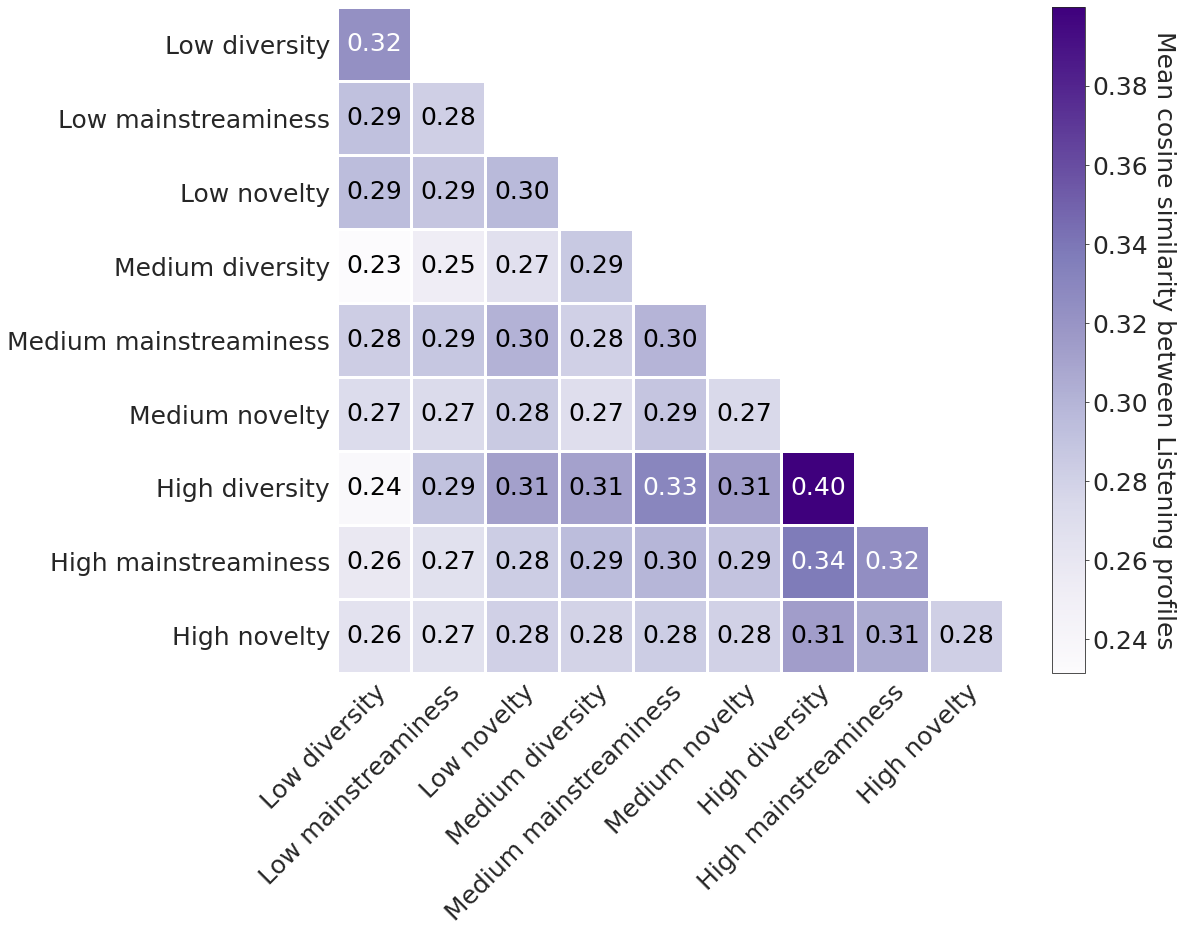

In [376]:
plt.rcParams.update({'figure.figsize' : (18,13.5), 'font.size': 25})
indices = ['Low diversity', 'Low mainstreaminess', 'Low novelty', 'Medium diversity', 'Medium mainstreaminess', 'Medium novelty', 'High diversity', 'High mainstreaminess', 'High novelty']
# indices = ['Diversity low', 'Mainstreaminess low', 'Novelty low', 'Diversity medium', 'Mainstreaminess medium', 'Novelty medium', 'Diversity high', 'Mainstreaminess high', 'Novelty high']
metric = 'cosine_similarity_UAM_nmf_mean'
# cosine_similarity_freebase_nmf_mean
# cosine_similarity_allmusic_mean
# cosine_similarity_UAM_nmf_mean
values = np.zeros((len(indices), len(indices)))
for i in range(len(indices)):
    for j in range(len(indices)):
        if j > i:
            values[i,j] = np.nan
        else:
            values[i,j] = results_shuffled_mul[(indices[i], indices[j])][metric]
# values = np.array([[1.33871,0.9094,0.7548],[0.9094, 1.01024,0.9921],[0.75481,0.9921,1.22287]])

fig, ax = plt.subplots()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

im, cbar = heatmap(values, indices, indices, ax=ax,
                   cmap="Purples", cbarlabel="Mean cosine similarity between Listening profiles",
                  title='')
texts = annotate_heatmap(im, valfmt="{x:.2f}")

fig.tight_layout()
# plt.savefig('figures/UAM_nmf_mean_cosine_all_user_groups.pdf',dpi=300, bbox_inches = "tight")
plt.show()

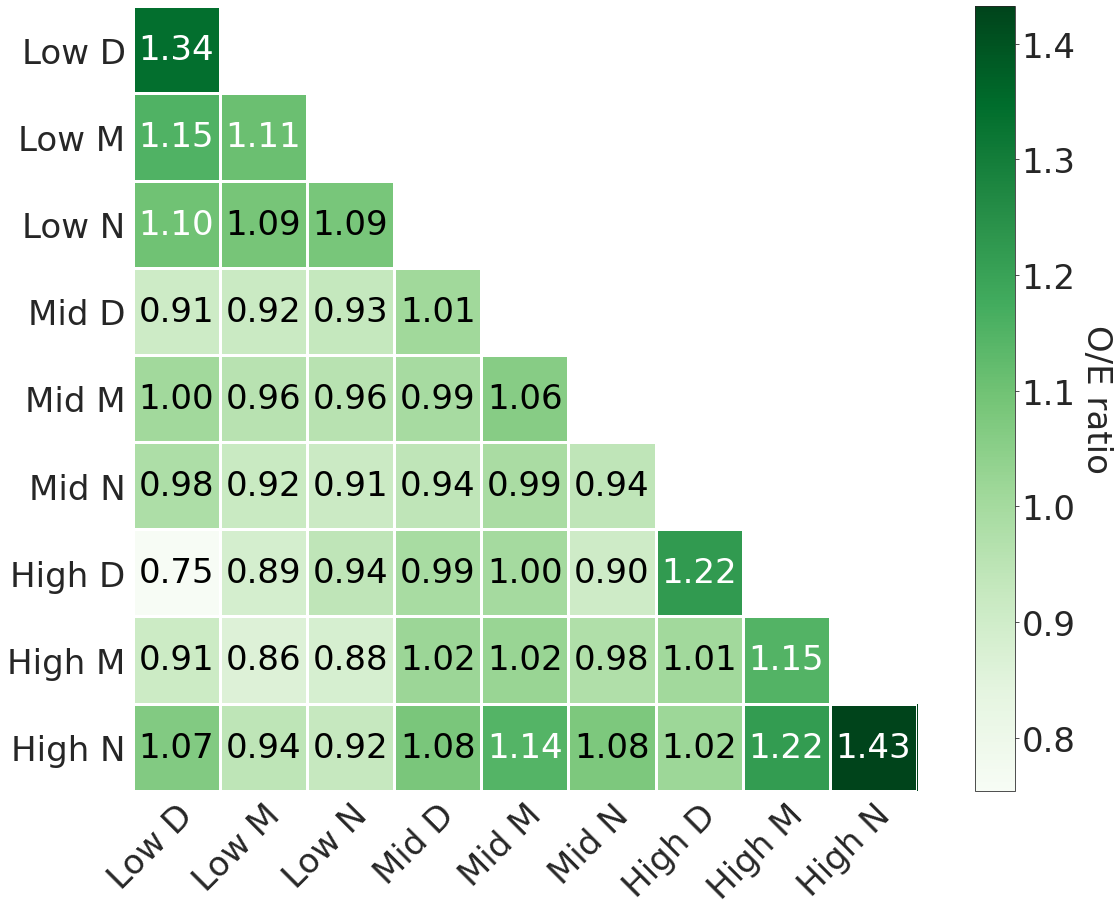

In [139]:
plt.rcParams.update({'figure.figsize' : (18,13.5), 'font.size': 34})
indices = ['Low diversity', 'Low mainstreaminess', 'Low novelty', 'Medium diversity', 'Medium mainstreaminess', 'Medium novelty', 'High diversity', 'High mainstreaminess', 'High novelty']
indices_short = ['Low D', 'Low M', 'Low N', 'Mid D', 'Mid M', 'Mid N', 'High D', 'High M', 'High N']

# indices = ['Diversity low', 'Mainstreaminess low', 'Novelty low', 'Diversity medium', 'Mainstreaminess medium', 'Novelty medium', 'Diversity high', 'Mainstreaminess high', 'Novelty high']
metric = 'real_expected_ratio'
# cosine_similarity_freebase_nmf_mean
# cosine_similarity_allmusic_mean
# cosine_similarity_UAM_nmf_mean
values = np.zeros((len(indices), len(indices)))
for i in range(len(indices)):
    for j in range(len(indices)):
        if j > i:
            values[i,j] = np.nan
        else:
            values[i,j] = (results_shuffled_mul_0[(indices[i], indices[j])][metric] + \
            results_shuffled_mul_1[(indices[i], indices[j])][metric] + \
            results_shuffled_mul_2[(indices[i], indices[j])][metric] + \
            results_shuffled_mul_3[(indices[i], indices[j])][metric] + \
            results_shuffled_mul_4[(indices[i], indices[j])][metric] + \
            results_shuffled_mul_5[(indices[i], indices[j])][metric] + \
            results_shuffled_mul_6[(indices[i], indices[j])][metric] + \
            results_shuffled_mul_7[(indices[i], indices[j])][metric] + \
            results_shuffled_mul_8[(indices[i], indices[j])][metric] + \
            results_shuffled_mul_9[(indices[i], indices[j])][metric]) / 10 

# values = np.array([[1.33871,0.9094,0.7548],[0.9094, 1.01024,0.9921],[0.75481,0.9921,1.22287]])

fig, ax = plt.subplots()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

im, cbar = heatmap(values, indices_short, indices_short, ax=ax,
                   cmap="Greens", cbarlabel="O/E ratio",
                  title='')
texts = annotate_heatmap(im, valfmt="{x:.2f}")

fig.tight_layout()
plt.savefig('figures/shuffled_mul_homophily_all_user_groups.pdf',dpi=300, bbox_inches = "tight")
plt.show()

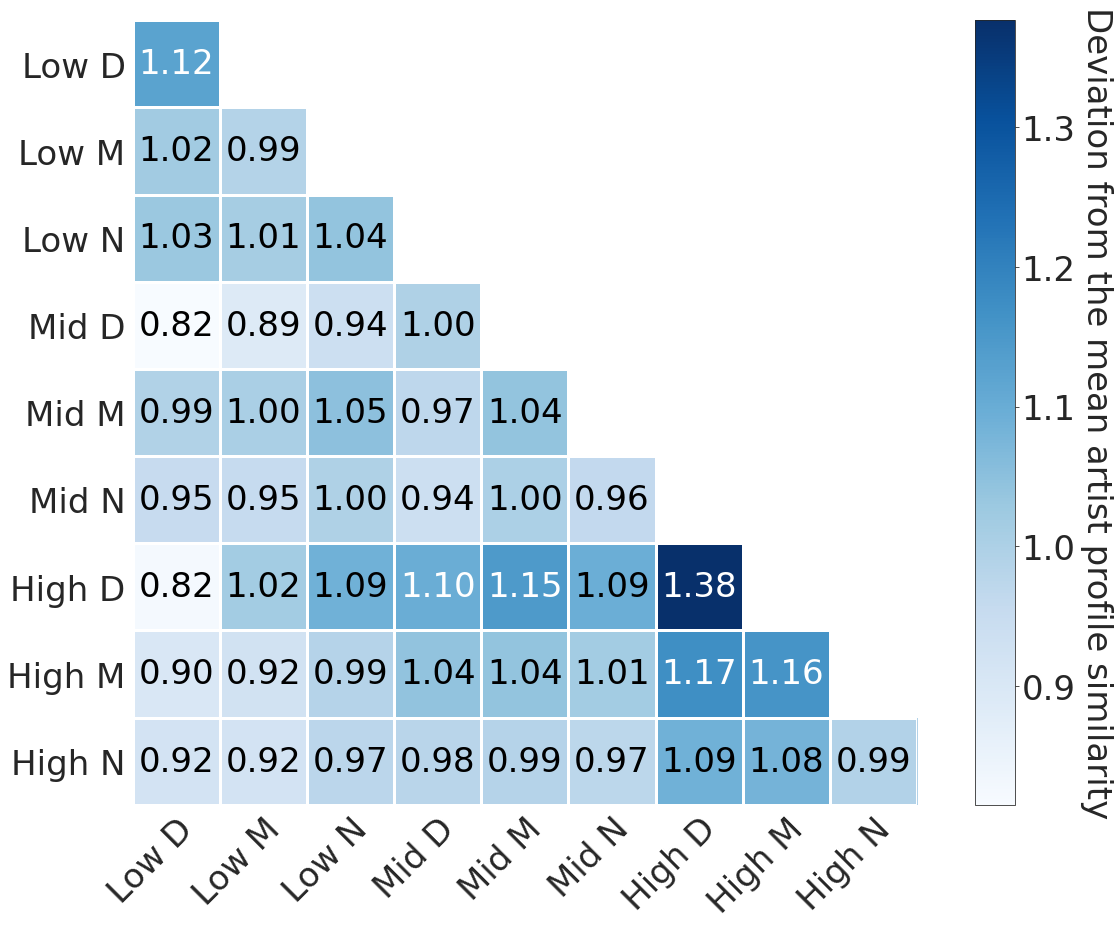

In [141]:
plt.rcParams.update({'figure.figsize' : (18,13.5), 'font.size': 34})
indices = ['Low diversity', 'Low mainstreaminess', 'Low novelty', 'Medium diversity', 'Medium mainstreaminess', 'Medium novelty', 'High diversity', 'High mainstreaminess', 'High novelty']
indices_short = ['Low D', 'Low M', 'Low N', 'Mid D', 'Mid M', 'Mid N', 'High D', 'High M', 'High N']
# indices = ['Diversity low', 'Mainstreaminess low', 'Novelty low', 'Diversity medium', 'Mainstreaminess medium', 'Novelty medium', 'Diversity high', 'Mainstreaminess high', 'Novelty high']
metric = 'cosine_similarity_UAM_nmf_diff_to_mean'
# cosine_similarity_freebase_nmf_mean
# cosine_similarity_allmusic_mean
# cosine_similarity_UAM_nmf_mean
values = np.zeros((len(indices), len(indices)))
for i in range(len(indices)):
    for j in range(len(indices)):
        if j > i:
            values[i,j] = np.nan
        else:
            values[i,j] = (results_shuffled_mul_0[(indices[i], indices[j])][metric] + \
            results_shuffled_mul_1[(indices[i], indices[j])][metric] + \
            results_shuffled_mul_2[(indices[i], indices[j])][metric] + \
            results_shuffled_mul_3[(indices[i], indices[j])][metric] + \
            results_shuffled_mul_4[(indices[i], indices[j])][metric] + \
            results_shuffled_mul_5[(indices[i], indices[j])][metric] + \
            results_shuffled_mul_6[(indices[i], indices[j])][metric] + \
            results_shuffled_mul_7[(indices[i], indices[j])][metric] + \
            results_shuffled_mul_8[(indices[i], indices[j])][metric] + \
            results_shuffled_mul_9[(indices[i], indices[j])][metric]) / 10 
# values = np.array([[1.33871,0.9094,0.7548],[0.9094, 1.01024,0.9921],[0.75481,0.9921,1.22287]])

fig, ax = plt.subplots()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

im, cbar = heatmap(values, indices_short, indices_short, ax=ax,
                   cmap="Blues", cbarlabel="Deviation from the mean artist profile similarity",
                  title='')
texts = annotate_heatmap(im, valfmt="{x:.2f}")

fig.tight_layout()
plt.savefig('figures/shuffled_mul_UAM_nmf_mean_cosine_all_user_groups_ratio.pdf',dpi=300, bbox_inches = "tight")
plt.show()

# Big break

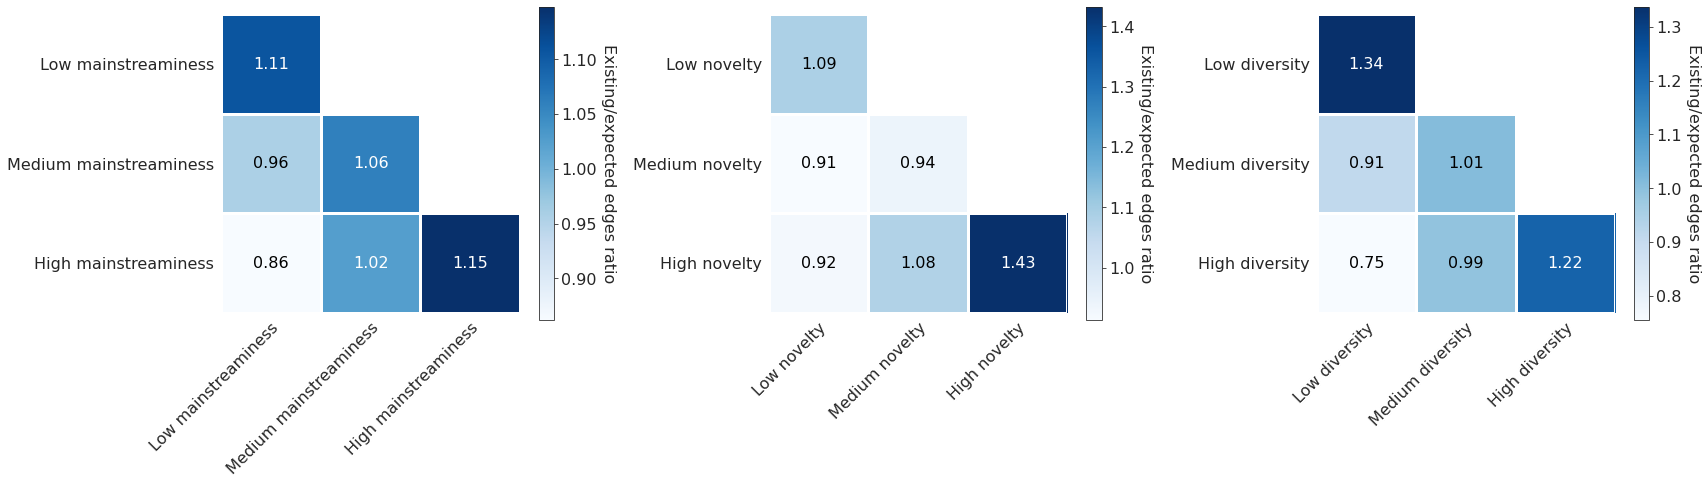

In [457]:
plt.rcParams.update({'figure.figsize' : (24,6.75), 'font.size': 16})

indices = ['Low mainstreaminess', 'Medium mainstreaminess', 'High mainstreaminess']
metric = 'real_expected_ratio'
# cosine_similarity_UAM_nmf_diff_to_mean
values = np.zeros((len(indices), len(indices)))
for i in range(len(indices)):
    for j in range(len(indices)):
        if j > i:
            values[i,j] = np.nan
        else:
            values[i,j] = results[(indices[i], indices[j])][metric]
# values = np.array([[1.33871,0.9094,0.7548],[0.9094, 1.01024,0.9921],[0.75481,0.9921,1.22287]])

fig, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)

im, cbar = heatmap(values, indices, indices, ax=ax1,
                   cmap="Blues", cbarlabel="Existing/expected edges ratio",
                  title='')
texts = annotate_heatmap(im, valfmt="{x:.2f}")

indices = ['Low novelty', 'Medium novelty', 'High novelty']
metric = 'real_expected_ratio'
values = np.zeros((len(indices), len(indices)))
for i in range(len(indices)):
    for j in range(len(indices)):
        if j > i:
            values[i,j] = np.nan
        else:
            values[i,j] = results[(indices[i], indices[j])][metric]
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)

im, cbar = heatmap(values, indices, indices, ax=ax2,
                   cmap="Blues", cbarlabel="Existing/expected edges ratio",
                  title='')
texts = annotate_heatmap(im, valfmt="{x:.2f}")

indices = ['Low diversity', 'Medium diversity', 'High diversity']
metric = 'real_expected_ratio'
values = np.zeros((len(indices), len(indices)))
for i in range(len(indices)):
    for j in range(len(indices)):
        if j > i:
            values[i,j] = np.nan
        else:
            values[i,j] = results[(indices[i], indices[j])][metric]
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax3.spines['left'].set_visible(False)

im, cbar = heatmap(values, indices, indices, ax=ax3,
                   cmap="Blues", cbarlabel="Existing/expected edges ratio",
                  title='')
texts = annotate_heatmap(im, valfmt="{x:.2f}")

fig.tight_layout()
plt.savefig('figures/single_homophily_mainstreaminess_novelty_diversity_user_groups.pdf',dpi=300, bbox_inches = "tight")
plt.show()

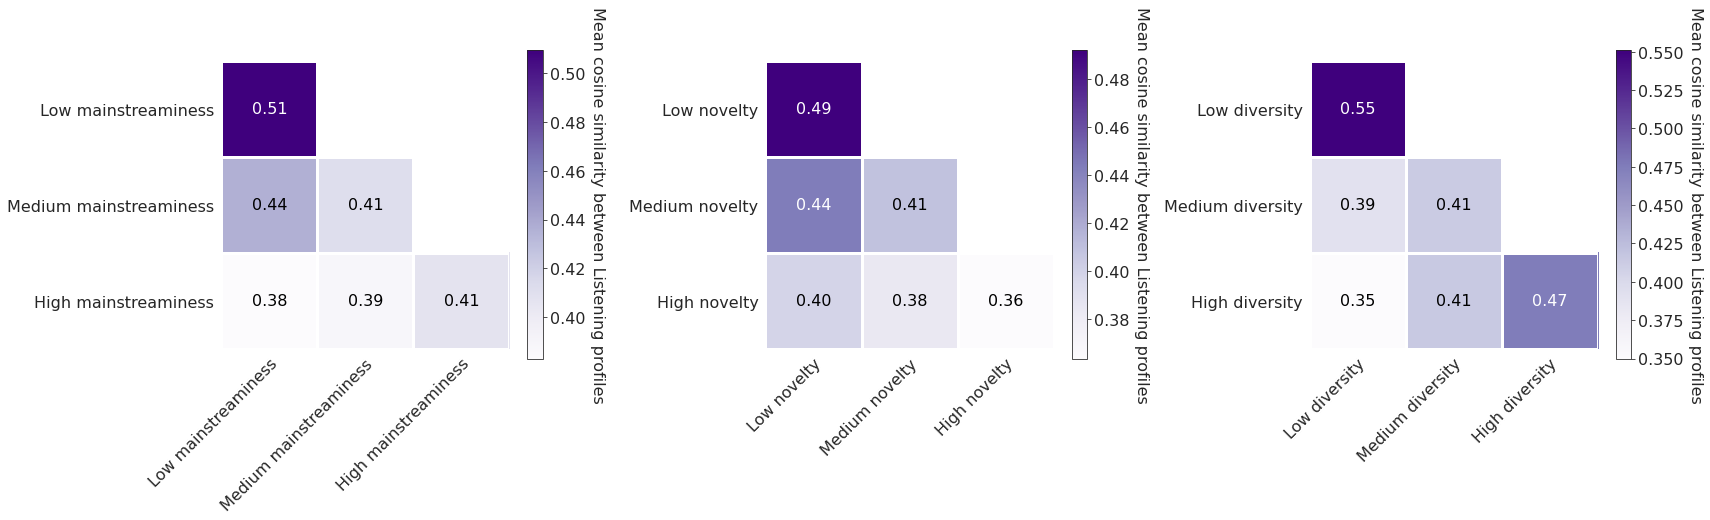

In [458]:
plt.rcParams.update({'figure.figsize' : (24,6.75), 'font.size': 16})

indices = ['Low mainstreaminess', 'Medium mainstreaminess', 'High mainstreaminess']
metric = 'cosine_similarity_UAM_nmf_mean'
# cosine_similarity_UAM_nmf_diff_to_mean
values = np.zeros((len(indices), len(indices)))
for i in range(len(indices)):
    for j in range(len(indices)):
        if j > i:
            values[i,j] = np.nan
        else:
            values[i,j] = results[(indices[i], indices[j])][metric]
# values = np.array([[1.33871,0.9094,0.7548],[0.9094, 1.01024,0.9921],[0.75481,0.9921,1.22287]])

fig, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)

im, cbar = heatmap(values, indices, indices, ax=ax1,
                   cmap="Purples", cbarlabel="Mean cosine similarity between Listening profiles",
                  title='')
texts = annotate_heatmap(im, valfmt="{x:.2f}")

indices = ['Low novelty', 'Medium novelty', 'High novelty']
metric = 'cosine_similarity_UAM_nmf_mean'
values = np.zeros((len(indices), len(indices)))
for i in range(len(indices)):
    for j in range(len(indices)):
        if j > i:
            values[i,j] = np.nan
        else:
            values[i,j] = results[(indices[i], indices[j])][metric]
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)

im, cbar = heatmap(values, indices, indices, ax=ax2,
                   cmap="Purples", cbarlabel="Mean cosine similarity between Listening profiles",
                  title='')
texts = annotate_heatmap(im, valfmt="{x:.2f}")

indices = ['Low diversity', 'Medium diversity', 'High diversity']
metric = 'cosine_similarity_UAM_nmf_mean'
values = np.zeros((len(indices), len(indices)))
for i in range(len(indices)):
    for j in range(len(indices)):
        if j > i:
            values[i,j] = np.nan
        else:
            values[i,j] = results[(indices[i], indices[j])][metric]
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax3.spines['left'].set_visible(False)

im, cbar = heatmap(values, indices, indices, ax=ax3,
                   cmap="Purples", cbarlabel="Mean cosine similarity between Listening profiles",
                  title='')
texts = annotate_heatmap(im, valfmt="{x:.2f}")

fig.tight_layout()
plt.savefig('figures/single_cosine_similarity_mean_mainstreaminess_novelty_diversity_user_groups.pdf',dpi=300, bbox_inches = "tight")
plt.show()

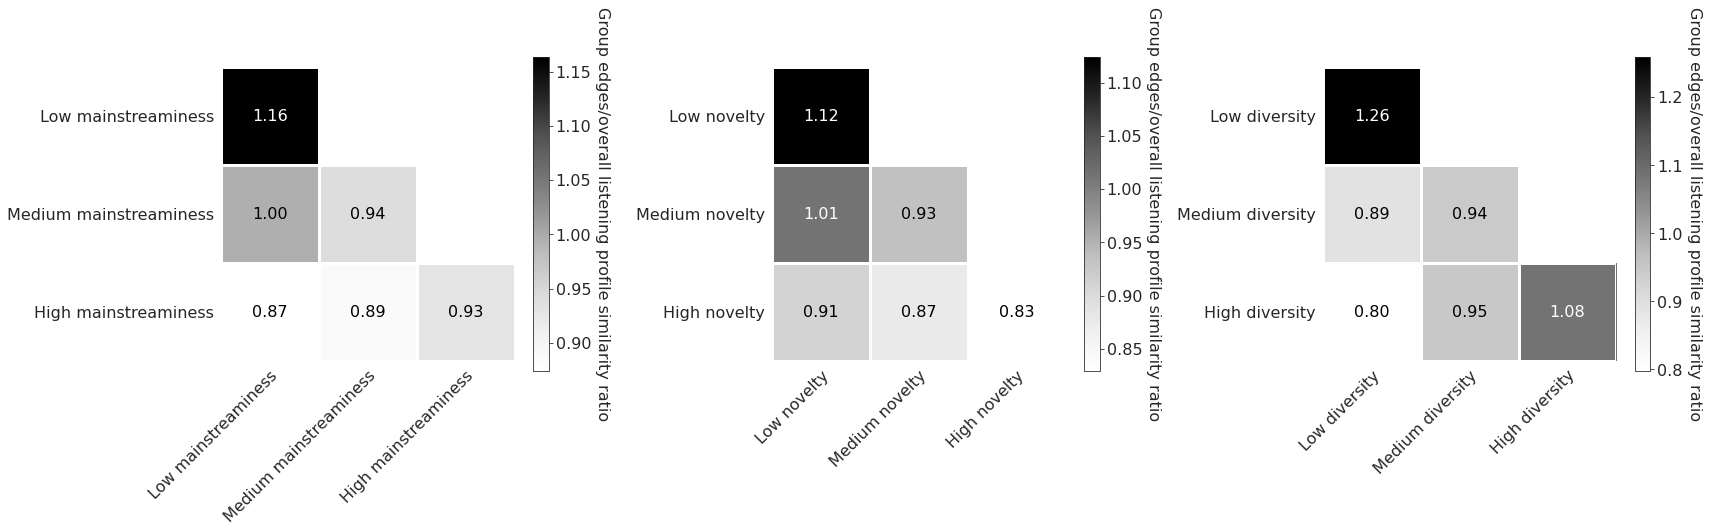

In [459]:
plt.rcParams.update({'figure.figsize' : (24,6.75), 'font.size': 16})

indices = ['Low mainstreaminess', 'Medium mainstreaminess', 'High mainstreaminess']
metric = 'cosine_similarity_UAM_nmf_diff_to_mean'
# cosine_similarity_UAM_nmf_diff_to_mean
values = np.zeros((len(indices), len(indices)))
for i in range(len(indices)):
    for j in range(len(indices)):
        if j > i:
            values[i,j] = np.nan
        else:
            values[i,j] = results[(indices[i], indices[j])][metric]
# values = np.array([[1.33871,0.9094,0.7548],[0.9094, 1.01024,0.9921],[0.75481,0.9921,1.22287]])

fig, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)

im, cbar = heatmap(values, indices, indices, ax=ax1,
                   cmap="Greys", cbarlabel="Group edges/overall listening profile similarity ratio",
                  title='')
texts = annotate_heatmap(im, valfmt="{x:.2f}")

indices = ['Low novelty', 'Medium novelty', 'High novelty']
metric = 'cosine_similarity_UAM_nmf_diff_to_mean'
values = np.zeros((len(indices), len(indices)))
for i in range(len(indices)):
    for j in range(len(indices)):
        if j > i:
            values[i,j] = np.nan
        else:
            values[i,j] = results[(indices[i], indices[j])][metric]
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)

im, cbar = heatmap(values, indices, indices, ax=ax2,
                   cmap="Greys", cbarlabel="Group edges/overall listening profile similarity ratio",
                  title='')
texts = annotate_heatmap(im, valfmt="{x:.2f}")

indices = ['Low diversity', 'Medium diversity', 'High diversity']
metric = 'cosine_similarity_UAM_nmf_diff_to_mean'
values = np.zeros((len(indices), len(indices)))
for i in range(len(indices)):
    for j in range(len(indices)):
        if j > i:
            values[i,j] = np.nan
        else:
            values[i,j] = results[(indices[i], indices[j])][metric]
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax3.spines['left'].set_visible(False)

im, cbar = heatmap(values, indices, indices, ax=ax3,
                   cmap="Greys", cbarlabel="Group edges/overall listening profile similarity ratio",
                  title='')
texts = annotate_heatmap(im, valfmt="{x:.2f}")

fig.tight_layout()
plt.savefig('figures/single_cosine_similarity_diff_mainstreaminess_novelty_diversity_user_groups.pdf',dpi=300, bbox_inches = "tight")
plt.show()

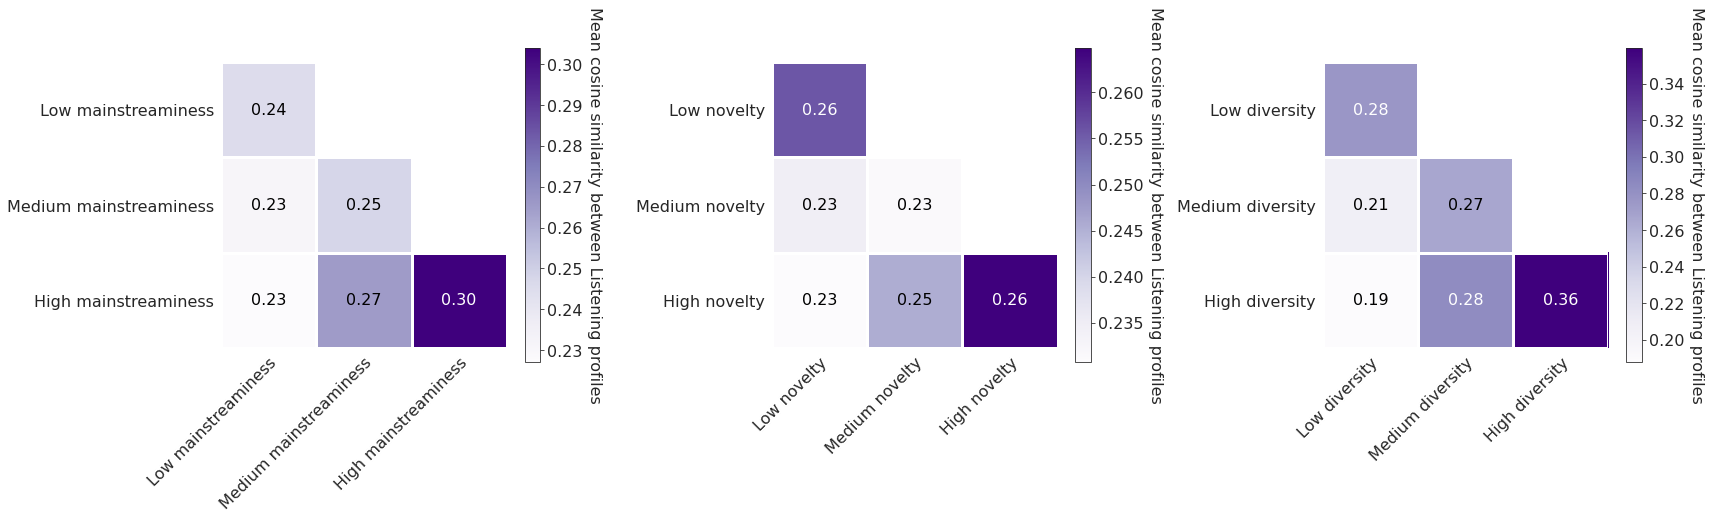

In [465]:
plt.rcParams.update({'figure.figsize' : (24,6.75), 'font.size': 16})

indices = ['Low mainstreaminess', 'Medium mainstreaminess', 'High mainstreaminess']
metric = 'cosine_similarity_UAM_nmf_mean'
# cosine_similarity_UAM_nmf_diff_to_mean
values = np.zeros((len(indices), len(indices)))
for i in range(len(indices)):
    for j in range(len(indices)):
        if j > i:
            values[i,j] = np.nan
        else:
            values[i,j] = results_conf[(indices[i], indices[j])][metric]
# values = np.array([[1.33871,0.9094,0.7548],[0.9094, 1.01024,0.9921],[0.75481,0.9921,1.22287]])

fig, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)

im, cbar = heatmap(values, indices, indices, ax=ax1,
                   cmap="Purples", cbarlabel="Mean cosine similarity between Listening profiles",
                  title='')
texts = annotate_heatmap(im, valfmt="{x:.2f}")

indices = ['Low novelty', 'Medium novelty', 'High novelty']
metric = 'cosine_similarity_UAM_nmf_mean'
values = np.zeros((len(indices), len(indices)))
for i in range(len(indices)):
    for j in range(len(indices)):
        if j > i:
            values[i,j] = np.nan
        else:
            values[i,j] = results_conf[(indices[i], indices[j])][metric]
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)

im, cbar = heatmap(values, indices, indices, ax=ax2,
                   cmap="Purples", cbarlabel="Mean cosine similarity between Listening profiles",
                  title='')
texts = annotate_heatmap(im, valfmt="{x:.2f}")

indices = ['Low diversity', 'Medium diversity', 'High diversity']
metric = 'cosine_similarity_UAM_nmf_mean'
values = np.zeros((len(indices), len(indices)))
for i in range(len(indices)):
    for j in range(len(indices)):
        if j > i:
            values[i,j] = np.nan
        else:
            values[i,j] = results_conf[(indices[i], indices[j])][metric]
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax3.spines['left'].set_visible(False)

im, cbar = heatmap(values, indices, indices, ax=ax3,
                   cmap="Purples", cbarlabel="Mean cosine similarity between Listening profiles",
                  title='')
texts = annotate_heatmap(im, valfmt="{x:.2f}")

fig.tight_layout()
plt.savefig('figures/single_conf_cosine_similarity_mean_singular_mainstreaminess_novelty_diversity_user_groups.pdf',dpi=300, bbox_inches = "tight")
plt.show()

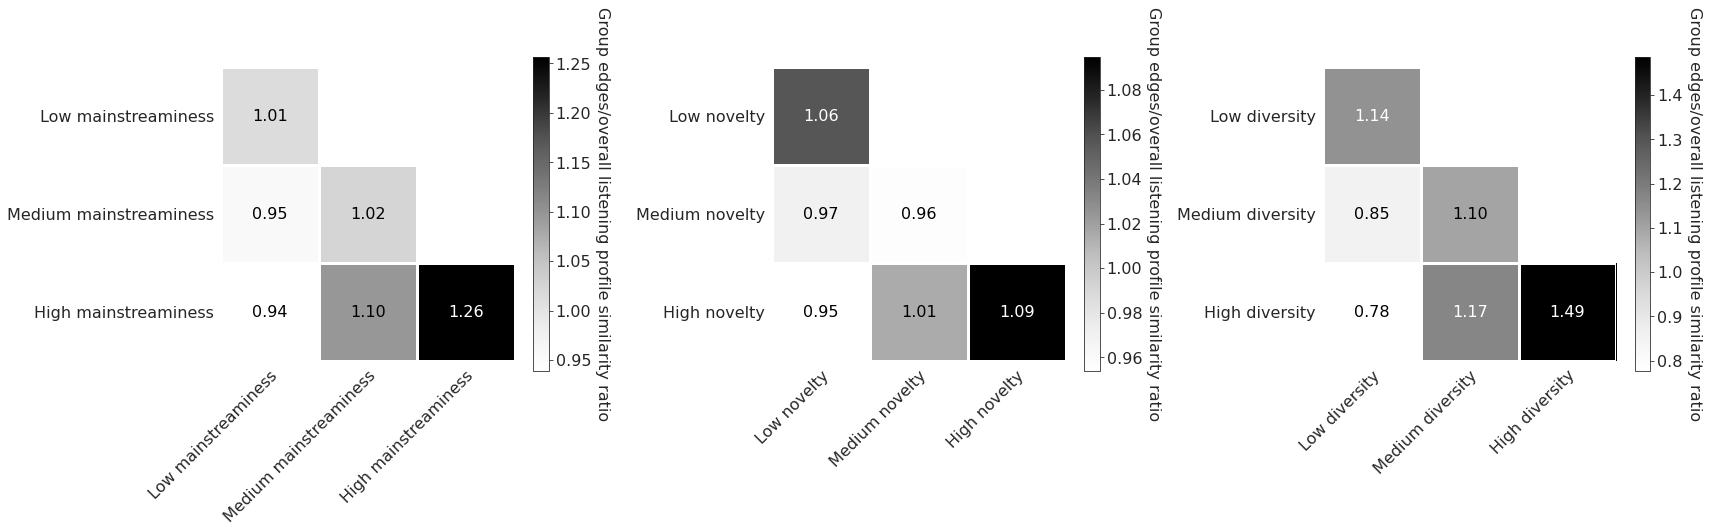

In [461]:
plt.rcParams.update({'figure.figsize' : (24,6.75), 'font.size': 16})

indices = ['Low mainstreaminess', 'Medium mainstreaminess', 'High mainstreaminess']
metric = 'cosine_similarity_UAM_nmf_diff_to_mean'
# cosine_similarity_UAM_nmf_diff_to_mean
values = np.zeros((len(indices), len(indices)))
for i in range(len(indices)):
    for j in range(len(indices)):
        if j > i:
            values[i,j] = np.nan
        else:
            values[i,j] = results_conf[(indices[i], indices[j])][metric]
# values = np.array([[1.33871,0.9094,0.7548],[0.9094, 1.01024,0.9921],[0.75481,0.9921,1.22287]])

fig, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)

im, cbar = heatmap(values, indices, indices, ax=ax1,
                   cmap="Greys", cbarlabel="Group edges/overall listening profile similarity ratio",
                  title='')
texts = annotate_heatmap(im, valfmt="{x:.2f}")

indices = ['Low novelty', 'Medium novelty', 'High novelty']
metric = 'cosine_similarity_UAM_nmf_diff_to_mean'
values = np.zeros((len(indices), len(indices)))
for i in range(len(indices)):
    for j in range(len(indices)):
        if j > i:
            values[i,j] = np.nan
        else:
            values[i,j] = results_conf[(indices[i], indices[j])][metric]
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)

im, cbar = heatmap(values, indices, indices, ax=ax2,
                   cmap="Greys", cbarlabel="Group edges/overall listening profile similarity ratio",
                  title='')
texts = annotate_heatmap(im, valfmt="{x:.2f}")

indices = ['Low diversity', 'Medium diversity', 'High diversity']
metric = 'cosine_similarity_UAM_nmf_diff_to_mean'
values = np.zeros((len(indices), len(indices)))
for i in range(len(indices)):
    for j in range(len(indices)):
        if j > i:
            values[i,j] = np.nan
        else:
            values[i,j] = results_conf[(indices[i], indices[j])][metric]
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax3.spines['left'].set_visible(False)

im, cbar = heatmap(values, indices, indices, ax=ax3,
                   cmap="Greys", cbarlabel="Group edges/overall listening profile similarity ratio",
                  title='')
texts = annotate_heatmap(im, valfmt="{x:.2f}")

fig.tight_layout()
plt.savefig('figures/single_conf_cosine_similarity_diff_random_mainstreaminess_novelty_diversity_user_groups.pdf',dpi=300, bbox_inches = "tight")
plt.show()

# Create random graph by preserving number of connections for mainstreaminess

In [416]:
edge_groups = {}

for index, row in links_df.groupby(['user1_user_groups_mainstreaminess_global', 
                  'user2_user_groups_mainstreaminess_global']).size().reset_index(name='Count').iterrows():
    edge_groups[(
        row['user1_user_groups_mainstreaminess_global'],
        row['user2_user_groups_mainstreaminess_global']
    )] = links_df[
        (links_df['user1_user_groups_mainstreaminess_global']==row['user1_user_groups_mainstreaminess_global'])&
        (links_df['user2_user_groups_mainstreaminess_global']==row['user2_user_groups_mainstreaminess_global'])
    ][['user1_user_id', 'user2_user_id']]
    
merged_edge_groups = {}
for key in edge_groups:
    if key in merged_edge_groups or (key[1], key[0]) in merged_edge_groups:
        continue
    if (key[1], key[0]) in edge_groups and key[0]!=key[1]:
        tmp_df = pd.DataFrame()
        tmp_df['user1_user_id'] = pd.Series(edge_groups[(key[1], key[0])]['user2_user_id'])
        tmp_df['user2_user_id'] = pd.Series(edge_groups[(key[1], key[0])]['user1_user_id'])
        merged_edge_groups[key] = edge_groups[key].append(tmp_df, ignore_index=True)
    else:
        merged_edge_groups[key] = edge_groups[key]
        
shuffled_edge_groups = {}
shuffled_mainstreaminess_links_mul_random_df = pd.DataFrame(columns=['user1_user_id', 'user2_user_id'])
for key in merged_edge_groups:
    tmp_df = pd.DataFrame(merged_edge_groups[key])
    user2_df = tmp_df.drop('user1_user_id', axis=1)
    user2_df = user2_df.sample(frac=1)
    tmp_df['user2_user_id'] = user2_df['user2_user_id'].values
    shuffled_edge_groups[key] = tmp_df
    shuffled_mainstreaminess_links_mul_random_df = shuffled_mainstreaminess_links_mul_random_df.append(tmp_df, ignore_index=True)

In [422]:
users1_shuffled_mainstreaminess_mul_df = pd.DataFrame([x for x in shuffled_mainstreaminess_links_mul_random_df.user1_user_id.values]).rename(columns={0:'user_id'}).merge(users_df, how='left', on='user_id').add_prefix('user1_')
users2_shuffled_mainstreaminess_mul_df = pd.DataFrame([x for x in shuffled_mainstreaminess_links_mul_random_df.user2_user_id.values]).rename(columns={0:'user_id'}).merge(users_df, how='left', on='user_id').add_prefix('user2_')
links_shuffled_mainstreaminess_mul_df = pd.concat([users1_shuffled_mainstreaminess_mul_df, users2_shuffled_mainstreaminess_mul_df.set_index(users1_shuffled_mainstreaminess_mul_df.index)], axis=1)
links_shuffled_mainstreaminess_mul_df['label'] = 1
links_shuffled_mainstreaminess_mul_df = calculate_cosine_similarity_for_vector_features(links_shuffled_mainstreaminess_mul_df, ['allmusic_genre_array', 'freebase_nmf_array', 'UAM_nmf_array'])

In [434]:
namings_map = {
    'mainstreaminess_global':'mainstreaminess',
    'freebase_weighted_average_diversity':'diversity',
    'novelty_artist_avg_6months':'novelty'
}
keys = ['mainstreaminess_global|high', 
        'mainstreaminess_global|medium', 
        'mainstreaminess_global|low',
        'freebase_weighted_average_diversity|high',
        'freebase_weighted_average_diversity|medium',
        'freebase_weighted_average_diversity|low',
        'novelty_artist_avg_6months|high',
        'novelty_artist_avg_6months|medium',
        'novelty_artist_avg_6months|low']
results_shuffled_mainstreaminess_mul = {}
for key1 in keys:
    for key2 in keys:
        metric1 = key1.split('|')[0]
        user_group1 = key1.split('|')[1]
        metric2 = key2.split('|')[0]
        user_group2 = key2.split('|')[1]
        if key1 == key2:
            cosine_similarity_allmusic_genre_array_values = links_shuffled_mainstreaminess_mul_df[(links_shuffled_mainstreaminess_mul_df['user1_user_groups_'+metric1+'_'+user_group1]==True)&((links_shuffled_mainstreaminess_mul_df['user2_user_groups_'+metric2+'_'+user_group2]==True))].cosine_similarity_allmusic_genre_array.values
            cosine_similarity_freebase_nmf_array_values = links_shuffled_mainstreaminess_mul_df[(links_shuffled_mainstreaminess_mul_df['user1_user_groups_'+metric1+'_'+user_group1]==True)&((links_shuffled_mainstreaminess_mul_df['user2_user_groups_'+metric2+'_'+user_group2]==True))].cosine_similarity_freebase_nmf_array.values
            cosine_similarity_UAM_nmf_array_values = links_shuffled_mainstreaminess_mul_df[(links_shuffled_mainstreaminess_mul_df['user1_user_groups_'+metric1+'_'+user_group1]==True)&((links_shuffled_mainstreaminess_mul_df['user2_user_groups_'+metric2+'_'+user_group2]==True))].cosine_similarity_UAM_nmf_array.values
        else:
            cosine_similarity_allmusic_genre_array_values = np.concatenate([links_shuffled_mainstreaminess_mul_df[(links_shuffled_mainstreaminess_mul_df['user1_user_groups_'+metric1+'_'+user_group1]==True)&((links_shuffled_mainstreaminess_mul_df['user2_user_groups_'+metric2+'_'+user_group2]==True))].cosine_similarity_allmusic_genre_array.values, links_shuffled_mainstreaminess_mul_df[(links_shuffled_mainstreaminess_mul_df['user1_user_groups_'+metric2+'_'+user_group2]==True)&((links_shuffled_mainstreaminess_mul_df['user2_user_groups_'+metric1+'_'+user_group1]==True))].cosine_similarity_allmusic_genre_array.values])
            cosine_similarity_freebase_nmf_array_values = np.concatenate([links_shuffled_mainstreaminess_mul_df[(links_shuffled_mainstreaminess_mul_df['user1_user_groups_'+metric1+'_'+user_group1]==True)&((links_shuffled_mainstreaminess_mul_df['user2_user_groups_'+metric2+'_'+user_group2]==True))].cosine_similarity_freebase_nmf_array.values, links_shuffled_mainstreaminess_mul_df[(links_shuffled_mainstreaminess_mul_df['user1_user_groups_'+metric2+'_'+user_group2]==True)&((links_shuffled_mainstreaminess_mul_df['user2_user_groups_'+metric1+'_'+user_group1]==True))].cosine_similarity_freebase_nmf_array.values])
            cosine_similarity_UAM_nmf_array_values = np.concatenate([links_shuffled_mainstreaminess_mul_df[(links_shuffled_mainstreaminess_mul_df['user1_user_groups_'+metric1+'_'+user_group1]==True)&((links_shuffled_mainstreaminess_mul_df['user2_user_groups_'+metric2+'_'+user_group2]==True))].cosine_similarity_UAM_nmf_array.values, links_shuffled_mainstreaminess_mul_df[(links_shuffled_mainstreaminess_mul_df['user1_user_groups_'+metric2+'_'+user_group2]==True)&((links_shuffled_mainstreaminess_mul_df['user2_user_groups_'+metric1+'_'+user_group1]==True))].cosine_similarity_UAM_nmf_array.values])
        results_key1 = user_group1.capitalize() + ' ' + namings_map[metric1]
        results_key2 = user_group2.capitalize() + ' ' + namings_map[metric2]
        results_shuffled_mainstreaminess_mul[(results_key1,results_key2)] = {
            'expected_edges':expected_edges, 
            'real_edges':real_edges, 
            'real_expected_ratio': real_edges/expected_edges,
            'cosine_similarity_allmusic_mean':np.nanmean(cosine_similarity_allmusic_genre_array_values),
            'cosine_similarity_freebase_nmf_mean':np.nanmean(cosine_similarity_freebase_nmf_array_values),
            'cosine_similarity_UAM_nmf_mean':np.nanmean(cosine_similarity_UAM_nmf_array_values),
            'cosine_similarity_allmusic_diff_to_mean':np.nanmean(cosine_similarity_allmusic_genre_array_values)/np.nanmean(links_shuffled_mainstreaminess_mul_df.cosine_similarity_allmusic_genre_array),
            'cosine_similarity_freebase_diff_to_mean':np.nanmean(cosine_similarity_freebase_nmf_array_values)/np.nanmean(links_shuffled_mainstreaminess_mul_df.cosine_similarity_freebase_nmf_array),
            'cosine_similarity_UAM_nmf_diff_to_mean':np.nanmean(cosine_similarity_UAM_nmf_array_values)/np.nanmean(links_shuffled_mainstreaminess_mul_df.cosine_similarity_UAM_nmf_array)
        }

# Create random graph by preserving number of connections for novelty

In [421]:
edge_groups = {}

for index, row in links_df.groupby(['user1_user_groups_novelty_artist_avg_6months', 
                  'user2_user_groups_novelty_artist_avg_6months']).size().reset_index(name='Count').iterrows():
    edge_groups[(
        row['user1_user_groups_novelty_artist_avg_6months'],
        row['user2_user_groups_novelty_artist_avg_6months']
    )] = links_df[
        (links_df['user1_user_groups_novelty_artist_avg_6months']==row['user1_user_groups_novelty_artist_avg_6months'])&
        (links_df['user2_user_groups_novelty_artist_avg_6months']==row['user2_user_groups_novelty_artist_avg_6months'])
    ][['user1_user_id', 'user2_user_id']]
    
merged_edge_groups = {}
for key in edge_groups:
    if key in merged_edge_groups or (key[1], key[0]) in merged_edge_groups:
        continue
    if (key[1], key[0]) in edge_groups and key[0]!=key[1]:
        tmp_df = pd.DataFrame()
        tmp_df['user1_user_id'] = pd.Series(edge_groups[(key[1], key[0])]['user2_user_id'])
        tmp_df['user2_user_id'] = pd.Series(edge_groups[(key[1], key[0])]['user1_user_id'])
        merged_edge_groups[key] = edge_groups[key].append(tmp_df, ignore_index=True)
    else:
        merged_edge_groups[key] = edge_groups[key]
        
shuffled_edge_groups = {}
shuffled_novelty_links_mul_random_df = pd.DataFrame(columns=['user1_user_id', 'user2_user_id'])
for key in merged_edge_groups:
    tmp_df = pd.DataFrame(merged_edge_groups[key])
    user2_df = tmp_df.drop('user1_user_id', axis=1)
    user2_df = user2_df.sample(frac=1)
    tmp_df['user2_user_id'] = user2_df['user2_user_id'].values
    shuffled_edge_groups[key] = tmp_df
    shuffled_novelty_links_mul_random_df = shuffled_novelty_links_mul_random_df.append(tmp_df, ignore_index=True)

In [424]:
users1_shuffled_novelty_mul_df = pd.DataFrame([x for x in shuffled_novelty_links_mul_random_df.user1_user_id.values]).rename(columns={0:'user_id'}).merge(users_df, how='left', on='user_id').add_prefix('user1_')
users2_shuffled_novelty_mul_df = pd.DataFrame([x for x in shuffled_novelty_links_mul_random_df.user2_user_id.values]).rename(columns={0:'user_id'}).merge(users_df, how='left', on='user_id').add_prefix('user2_')
links_shuffled_novelty_mul_df = pd.concat([users1_shuffled_novelty_mul_df, users2_shuffled_novelty_mul_df.set_index(users1_shuffled_novelty_mul_df.index)], axis=1)
links_shuffled_novelty_mul_df['label'] = 1
links_shuffled_novelty_mul_df = calculate_cosine_similarity_for_vector_features(links_shuffled_novelty_mul_df, ['allmusic_genre_array', 'freebase_nmf_array', 'UAM_nmf_array'])

In [435]:
namings_map = {
    'mainstreaminess_global':'mainstreaminess',
    'freebase_weighted_average_diversity':'diversity',
    'novelty_artist_avg_6months':'novelty'
}
keys = ['mainstreaminess_global|high', 
        'mainstreaminess_global|medium', 
        'mainstreaminess_global|low',
        'freebase_weighted_average_diversity|high',
        'freebase_weighted_average_diversity|medium',
        'freebase_weighted_average_diversity|low',
        'novelty_artist_avg_6months|high',
        'novelty_artist_avg_6months|medium',
        'novelty_artist_avg_6months|low']
results_shuffled_novelty_mul = {}
for key1 in keys:
    for key2 in keys:
        metric1 = key1.split('|')[0]
        user_group1 = key1.split('|')[1]
        metric2 = key2.split('|')[0]
        user_group2 = key2.split('|')[1]
        if key1 == key2:
            cosine_similarity_allmusic_genre_array_values = links_shuffled_novelty_mul_df[(links_shuffled_novelty_mul_df['user1_user_groups_'+metric1+'_'+user_group1]==True)&((links_shuffled_novelty_mul_df['user2_user_groups_'+metric2+'_'+user_group2]==True))].cosine_similarity_allmusic_genre_array.values
            cosine_similarity_freebase_nmf_array_values = links_shuffled_novelty_mul_df[(links_shuffled_novelty_mul_df['user1_user_groups_'+metric1+'_'+user_group1]==True)&((links_shuffled_novelty_mul_df['user2_user_groups_'+metric2+'_'+user_group2]==True))].cosine_similarity_freebase_nmf_array.values
            cosine_similarity_UAM_nmf_array_values = links_shuffled_novelty_mul_df[(links_shuffled_novelty_mul_df['user1_user_groups_'+metric1+'_'+user_group1]==True)&((links_shuffled_novelty_mul_df['user2_user_groups_'+metric2+'_'+user_group2]==True))].cosine_similarity_UAM_nmf_array.values
        else:
            cosine_similarity_allmusic_genre_array_values = np.concatenate([links_shuffled_novelty_mul_df[(links_shuffled_novelty_mul_df['user1_user_groups_'+metric1+'_'+user_group1]==True)&((links_shuffled_novelty_mul_df['user2_user_groups_'+metric2+'_'+user_group2]==True))].cosine_similarity_allmusic_genre_array.values, links_shuffled_novelty_mul_df[(links_shuffled_novelty_mul_df['user1_user_groups_'+metric2+'_'+user_group2]==True)&((links_shuffled_novelty_mul_df['user2_user_groups_'+metric1+'_'+user_group1]==True))].cosine_similarity_allmusic_genre_array.values])
            cosine_similarity_freebase_nmf_array_values = np.concatenate([links_shuffled_novelty_mul_df[(links_shuffled_novelty_mul_df['user1_user_groups_'+metric1+'_'+user_group1]==True)&((links_shuffled_novelty_mul_df['user2_user_groups_'+metric2+'_'+user_group2]==True))].cosine_similarity_freebase_nmf_array.values, links_shuffled_novelty_mul_df[(links_shuffled_novelty_mul_df['user1_user_groups_'+metric2+'_'+user_group2]==True)&((links_shuffled_novelty_mul_df['user2_user_groups_'+metric1+'_'+user_group1]==True))].cosine_similarity_freebase_nmf_array.values])
            cosine_similarity_UAM_nmf_array_values = np.concatenate([links_shuffled_novelty_mul_df[(links_shuffled_novelty_mul_df['user1_user_groups_'+metric1+'_'+user_group1]==True)&((links_shuffled_novelty_mul_df['user2_user_groups_'+metric2+'_'+user_group2]==True))].cosine_similarity_UAM_nmf_array.values, links_shuffled_novelty_mul_df[(links_shuffled_novelty_mul_df['user1_user_groups_'+metric2+'_'+user_group2]==True)&((links_shuffled_novelty_mul_df['user2_user_groups_'+metric1+'_'+user_group1]==True))].cosine_similarity_UAM_nmf_array.values])
        results_key1 = user_group1.capitalize() + ' ' + namings_map[metric1]
        results_key2 = user_group2.capitalize() + ' ' + namings_map[metric2]
        results_shuffled_novelty_mul[(results_key1,results_key2)] = {
            'expected_edges':expected_edges, 
            'real_edges':real_edges, 
            'real_expected_ratio': real_edges/expected_edges,
            'cosine_similarity_allmusic_mean':np.nanmean(cosine_similarity_allmusic_genre_array_values),
            'cosine_similarity_freebase_nmf_mean':np.nanmean(cosine_similarity_freebase_nmf_array_values),
            'cosine_similarity_UAM_nmf_mean':np.nanmean(cosine_similarity_UAM_nmf_array_values),
            'cosine_similarity_allmusic_diff_to_mean':np.nanmean(cosine_similarity_allmusic_genre_array_values)/np.nanmean(links_shuffled_novelty_mul_df.cosine_similarity_allmusic_genre_array),
            'cosine_similarity_freebase_diff_to_mean':np.nanmean(cosine_similarity_freebase_nmf_array_values)/np.nanmean(links_shuffled_novelty_mul_df.cosine_similarity_freebase_nmf_array),
            'cosine_similarity_UAM_nmf_diff_to_mean':np.nanmean(cosine_similarity_UAM_nmf_array_values)/np.nanmean(links_shuffled_novelty_mul_df.cosine_similarity_UAM_nmf_array)
        }

# Create random graph by preserving number of connections for novelty


In [426]:
edge_groups = {}

for index, row in links_df.groupby(['user1_user_groups_freebase_weighted_average_diversity', 
                  'user2_user_groups_freebase_weighted_average_diversity']).size().reset_index(name='Count').iterrows():
    edge_groups[(
        row['user1_user_groups_freebase_weighted_average_diversity'],
        row['user2_user_groups_freebase_weighted_average_diversity']
    )] = links_df[
        (links_df['user1_user_groups_freebase_weighted_average_diversity']==row['user1_user_groups_freebase_weighted_average_diversity'])&
        (links_df['user2_user_groups_freebase_weighted_average_diversity']==row['user2_user_groups_freebase_weighted_average_diversity'])
    ][['user1_user_id', 'user2_user_id']]
    
merged_edge_groups = {}
for key in edge_groups:
    if key in merged_edge_groups or (key[1], key[0]) in merged_edge_groups:
        continue
    if (key[1], key[0]) in edge_groups and key[0]!=key[1]:
        tmp_df = pd.DataFrame()
        tmp_df['user1_user_id'] = pd.Series(edge_groups[(key[1], key[0])]['user2_user_id'])
        tmp_df['user2_user_id'] = pd.Series(edge_groups[(key[1], key[0])]['user1_user_id'])
        merged_edge_groups[key] = edge_groups[key].append(tmp_df, ignore_index=True)
    else:
        merged_edge_groups[key] = edge_groups[key]
        
shuffled_edge_groups = {}
shuffled_diversity_links_mul_random_df = pd.DataFrame(columns=['user1_user_id', 'user2_user_id'])
for key in merged_edge_groups:
    tmp_df = pd.DataFrame(merged_edge_groups[key])
    user2_df = tmp_df.drop('user1_user_id', axis=1)
    user2_df = user2_df.sample(frac=1)
    tmp_df['user2_user_id'] = user2_df['user2_user_id'].values
    shuffled_edge_groups[key] = tmp_df
    shuffled_diversity_links_mul_random_df = shuffled_diversity_links_mul_random_df.append(tmp_df, ignore_index=True)

In [427]:
users1_shuffled_diversity_mul_df = pd.DataFrame([x for x in shuffled_diversity_links_mul_random_df.user1_user_id.values]).rename(columns={0:'user_id'}).merge(users_df, how='left', on='user_id').add_prefix('user1_')
users2_shuffled_diversity_mul_df = pd.DataFrame([x for x in shuffled_diversity_links_mul_random_df.user2_user_id.values]).rename(columns={0:'user_id'}).merge(users_df, how='left', on='user_id').add_prefix('user2_')
links_shuffled_diversity_mul_df = pd.concat([users1_shuffled_diversity_mul_df, users2_shuffled_diversity_mul_df.set_index(users1_shuffled_diversity_mul_df.index)], axis=1)
links_shuffled_diversity_mul_df['label'] = 1
links_shuffled_diversity_mul_df = calculate_cosine_similarity_for_vector_features(links_shuffled_diversity_mul_df, ['allmusic_genre_array', 'freebase_nmf_array', 'UAM_nmf_array'])

In [436]:
namings_map = {
    'mainstreaminess_global':'mainstreaminess',
    'freebase_weighted_average_diversity':'diversity',
    'novelty_artist_avg_6months':'novelty'
}
keys = ['mainstreaminess_global|high', 
        'mainstreaminess_global|medium', 
        'mainstreaminess_global|low',
        'freebase_weighted_average_diversity|high',
        'freebase_weighted_average_diversity|medium',
        'freebase_weighted_average_diversity|low',
        'novelty_artist_avg_6months|high',
        'novelty_artist_avg_6months|medium',
        'novelty_artist_avg_6months|low']
results_shuffled_diversity_mul = {}
for key1 in keys:
    for key2 in keys:
        metric1 = key1.split('|')[0]
        user_group1 = key1.split('|')[1]
        metric2 = key2.split('|')[0]
        user_group2 = key2.split('|')[1]
        if key1 == key2:
            cosine_similarity_allmusic_genre_array_values = links_shuffled_diversity_mul_df[(links_shuffled_diversity_mul_df['user1_user_groups_'+metric1+'_'+user_group1]==True)&((links_shuffled_diversity_mul_df['user2_user_groups_'+metric2+'_'+user_group2]==True))].cosine_similarity_allmusic_genre_array.values
            cosine_similarity_freebase_nmf_array_values = links_shuffled_diversity_mul_df[(links_shuffled_diversity_mul_df['user1_user_groups_'+metric1+'_'+user_group1]==True)&((links_shuffled_diversity_mul_df['user2_user_groups_'+metric2+'_'+user_group2]==True))].cosine_similarity_freebase_nmf_array.values
            cosine_similarity_UAM_nmf_array_values = links_shuffled_diversity_mul_df[(links_shuffled_diversity_mul_df['user1_user_groups_'+metric1+'_'+user_group1]==True)&((links_shuffled_diversity_mul_df['user2_user_groups_'+metric2+'_'+user_group2]==True))].cosine_similarity_UAM_nmf_array.values
        else:
            cosine_similarity_allmusic_genre_array_values = np.concatenate([links_shuffled_diversity_mul_df[(links_shuffled_diversity_mul_df['user1_user_groups_'+metric1+'_'+user_group1]==True)&((links_shuffled_diversity_mul_df['user2_user_groups_'+metric2+'_'+user_group2]==True))].cosine_similarity_allmusic_genre_array.values, links_shuffled_diversity_mul_df[(links_shuffled_diversity_mul_df['user1_user_groups_'+metric2+'_'+user_group2]==True)&((links_shuffled_diversity_mul_df['user2_user_groups_'+metric1+'_'+user_group1]==True))].cosine_similarity_allmusic_genre_array.values])
            cosine_similarity_freebase_nmf_array_values = np.concatenate([links_shuffled_diversity_mul_df[(links_shuffled_diversity_mul_df['user1_user_groups_'+metric1+'_'+user_group1]==True)&((links_shuffled_diversity_mul_df['user2_user_groups_'+metric2+'_'+user_group2]==True))].cosine_similarity_freebase_nmf_array.values, links_shuffled_diversity_mul_df[(links_shuffled_diversity_mul_df['user1_user_groups_'+metric2+'_'+user_group2]==True)&((links_shuffled_diversity_mul_df['user2_user_groups_'+metric1+'_'+user_group1]==True))].cosine_similarity_freebase_nmf_array.values])
            cosine_similarity_UAM_nmf_array_values = np.concatenate([links_shuffled_diversity_mul_df[(links_shuffled_diversity_mul_df['user1_user_groups_'+metric1+'_'+user_group1]==True)&((links_shuffled_diversity_mul_df['user2_user_groups_'+metric2+'_'+user_group2]==True))].cosine_similarity_UAM_nmf_array.values, links_shuffled_diversity_mul_df[(links_shuffled_diversity_mul_df['user1_user_groups_'+metric2+'_'+user_group2]==True)&((links_shuffled_diversity_mul_df['user2_user_groups_'+metric1+'_'+user_group1]==True))].cosine_similarity_UAM_nmf_array.values])
        results_key1 = user_group1.capitalize() + ' ' + namings_map[metric1]
        results_key2 = user_group2.capitalize() + ' ' + namings_map[metric2]
        results_shuffled_diversity_mul[(results_key1,results_key2)] = {
            'expected_edges':expected_edges, 
            'real_edges':real_edges, 
            'real_expected_ratio': real_edges/expected_edges,
            'cosine_similarity_allmusic_mean':np.nanmean(cosine_similarity_allmusic_genre_array_values),
            'cosine_similarity_freebase_nmf_mean':np.nanmean(cosine_similarity_freebase_nmf_array_values),
            'cosine_similarity_UAM_nmf_mean':np.nanmean(cosine_similarity_UAM_nmf_array_values),
            'cosine_similarity_allmusic_diff_to_mean':np.nanmean(cosine_similarity_allmusic_genre_array_values)/np.nanmean(links_shuffled_diversity_mul_df.cosine_similarity_allmusic_genre_array),
            'cosine_similarity_freebase_diff_to_mean':np.nanmean(cosine_similarity_freebase_nmf_array_values)/np.nanmean(links_shuffled_diversity_mul_df.cosine_similarity_freebase_nmf_array),
            'cosine_similarity_UAM_nmf_diff_to_mean':np.nanmean(cosine_similarity_UAM_nmf_array_values)/np.nanmean(links_shuffled_diversity_mul_df.cosine_similarity_UAM_nmf_array)
        }

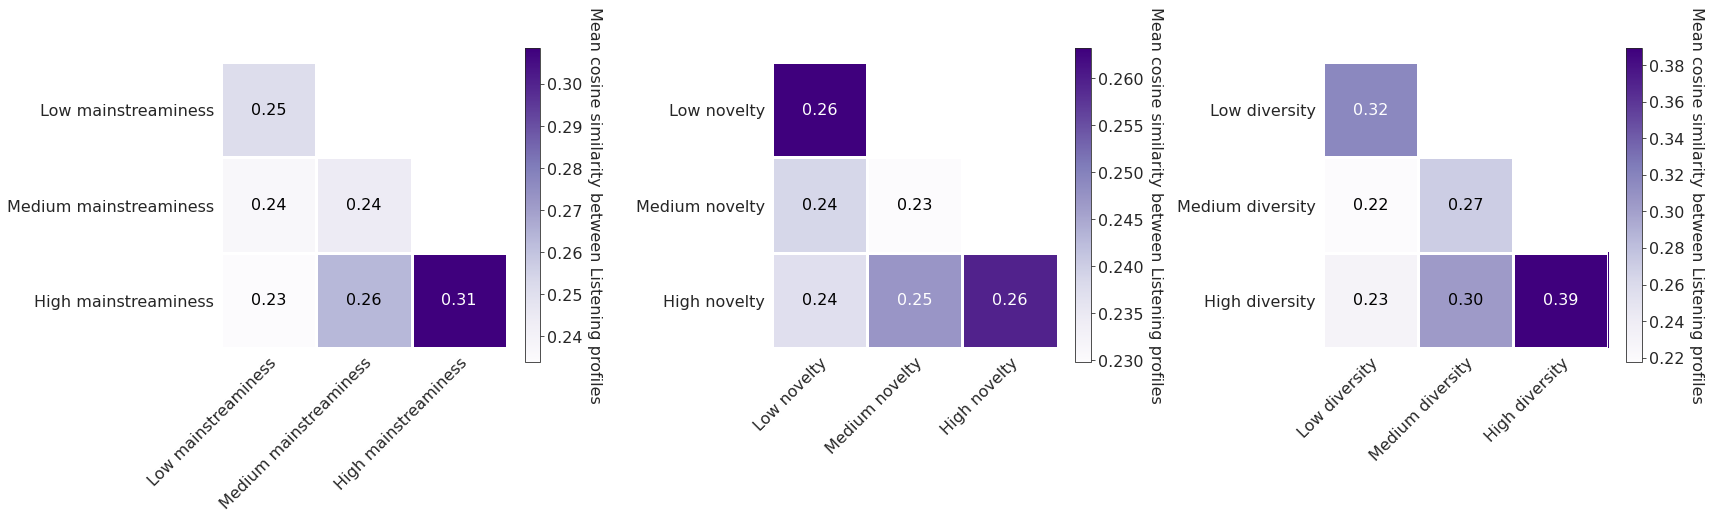

In [464]:
plt.rcParams.update({'figure.figsize' : (24,6.75), 'font.size': 16})

indices = ['Low mainstreaminess', 'Medium mainstreaminess', 'High mainstreaminess']
metric = 'cosine_similarity_UAM_nmf_mean'
# cosine_similarity_UAM_nmf_diff_to_mean
values = np.zeros((len(indices), len(indices)))
for i in range(len(indices)):
    for j in range(len(indices)):
        if j > i:
            values[i,j] = np.nan
        else:
            values[i,j] = results_shuffled_mainstreaminess_mul[(indices[i], indices[j])][metric]
# values = np.array([[1.33871,0.9094,0.7548],[0.9094, 1.01024,0.9921],[0.75481,0.9921,1.22287]])

fig, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)

im, cbar = heatmap(values, indices, indices, ax=ax1,
                   cmap="Purples", cbarlabel="Mean cosine similarity between Listening profiles",
                  title='')
texts = annotate_heatmap(im, valfmt="{x:.2f}")

indices = ['Low novelty', 'Medium novelty', 'High novelty']
metric = 'cosine_similarity_UAM_nmf_mean'
values = np.zeros((len(indices), len(indices)))
for i in range(len(indices)):
    for j in range(len(indices)):
        if j > i:
            values[i,j] = np.nan
        else:
            values[i,j] = results_shuffled_novelty_mul[(indices[i], indices[j])][metric]
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)

im, cbar = heatmap(values, indices, indices, ax=ax2,
                   cmap="Purples", cbarlabel="Mean cosine similarity between Listening profiles",
                  title='')
texts = annotate_heatmap(im, valfmt="{x:.2f}")

indices = ['Low diversity', 'Medium diversity', 'High diversity']
metric = 'cosine_similarity_UAM_nmf_mean'
values = np.zeros((len(indices), len(indices)))
for i in range(len(indices)):
    for j in range(len(indices)):
        if j > i:
            values[i,j] = np.nan
        else:
            values[i,j] = results_shuffled_diversity_mul[(indices[i], indices[j])][metric]
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax3.spines['left'].set_visible(False)

im, cbar = heatmap(values, indices, indices, ax=ax3,
                   cmap="Purples", cbarlabel="Mean cosine similarity between Listening profiles",
                  title='')
texts = annotate_heatmap(im, valfmt="{x:.2f}")

fig.tight_layout()
plt.savefig('figures/single_shuffle_cosine_similarity_mean_singular_mainstreaminess_novelty_diversity_user_groups.pdf',dpi=300, bbox_inches = "tight")
plt.show()

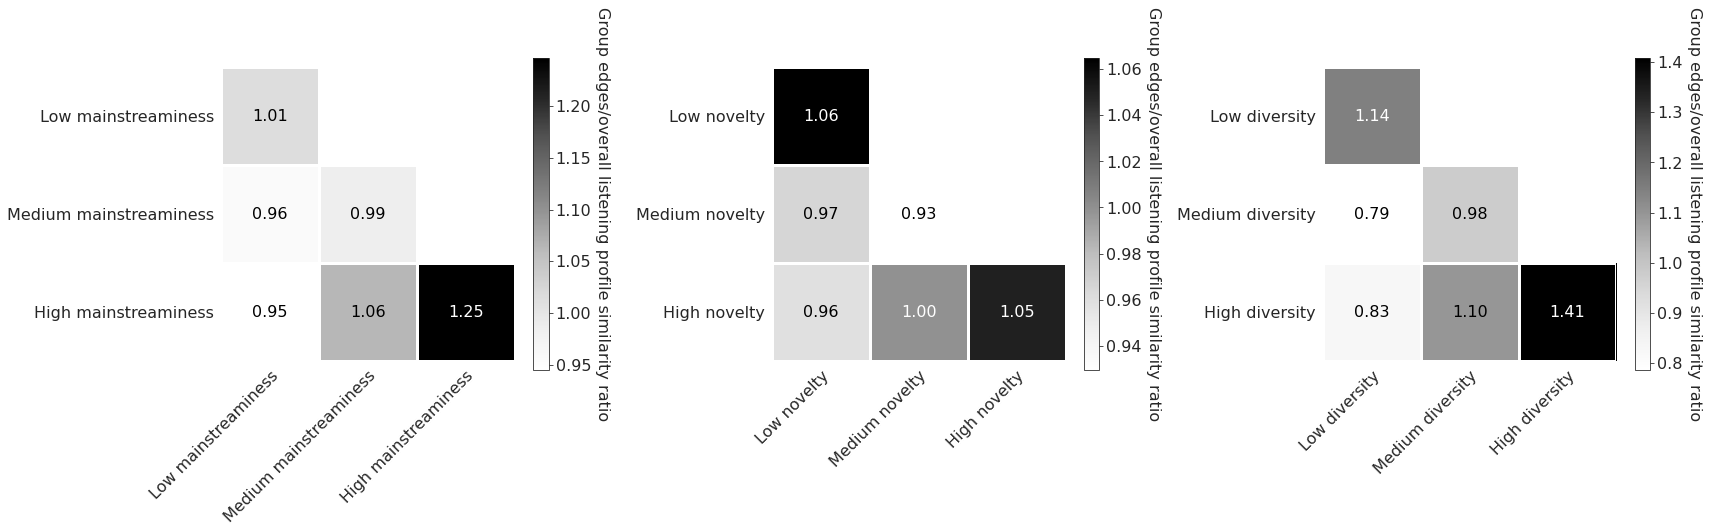

In [462]:
plt.rcParams.update({'figure.figsize' : (24,6.75), 'font.size': 16})

indices = ['Low mainstreaminess', 'Medium mainstreaminess', 'High mainstreaminess']
metric = 'cosine_similarity_UAM_nmf_diff_to_mean'
# cosine_similarity_UAM_nmf_diff_to_mean
values = np.zeros((len(indices), len(indices)))
for i in range(len(indices)):
    for j in range(len(indices)):
        if j > i:
            values[i,j] = np.nan
        else:
            values[i,j] = results_shuffled_mainstreaminess_mul[(indices[i], indices[j])][metric]
# values = np.array([[1.33871,0.9094,0.7548],[0.9094, 1.01024,0.9921],[0.75481,0.9921,1.22287]])

fig, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)

im, cbar = heatmap(values, indices, indices, ax=ax1,
                   cmap="Greys", cbarlabel="Group edges/overall listening profile similarity ratio",
                  title='')
texts = annotate_heatmap(im, valfmt="{x:.2f}")

indices = ['Low novelty', 'Medium novelty', 'High novelty']
metric = 'cosine_similarity_UAM_nmf_diff_to_mean'
values = np.zeros((len(indices), len(indices)))
for i in range(len(indices)):
    for j in range(len(indices)):
        if j > i:
            values[i,j] = np.nan
        else:
            values[i,j] = results_shuffled_novelty_mul[(indices[i], indices[j])][metric]
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)

im, cbar = heatmap(values, indices, indices, ax=ax2,
                   cmap="Greys", cbarlabel="Group edges/overall listening profile similarity ratio",
                  title='')
texts = annotate_heatmap(im, valfmt="{x:.2f}")

indices = ['Low diversity', 'Medium diversity', 'High diversity']
metric = 'cosine_similarity_UAM_nmf_diff_to_mean'
values = np.zeros((len(indices), len(indices)))
for i in range(len(indices)):
    for j in range(len(indices)):
        if j > i:
            values[i,j] = np.nan
        else:
            values[i,j] = results_shuffled_diversity_mul[(indices[i], indices[j])][metric]
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax3.spines['left'].set_visible(False)

im, cbar = heatmap(values, indices, indices, ax=ax3,
                   cmap="Greys", cbarlabel="Group edges/overall listening profile similarity ratio",
                  title='')
texts = annotate_heatmap(im, valfmt="{x:.2f}")

fig.tight_layout()
plt.savefig('figures/single_shuffle_cosine_similarity_diff_singular_mainstreaminess_novelty_diversity_user_groups.pdf',dpi=300, bbox_inches = "tight")
plt.show()